In [16]:
##Import Packages


import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
## Load Datasets available for this example

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

train.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
test.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

test['SalePrice'] = 0


In [14]:
## Understanding and looking at the data


def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [15]:
details = rstr(train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 80)
___________________________
Data types:
 object     43
int64      34
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.000,"[208500, 181500, 223500, 140000, 250000, 14300...",1.883,6.536,1.000
OverallQual,int64,1460,10,0,0.000,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",0.217,0.096,0.791
GrLivArea,int64,1460,861,0,0.000,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209...",1.367,4.895,0.709
GarageCars,int64,1460,5,0,0.000,"[2, 3, 1, 0, 4]",-0.343,0.221,0.640
GarageArea,int64,1460,441,0,0.000,"[548, 460, 608, 642, 836, 480, 636, 484, 468, ...",0.180,0.917,0.623
...,...,...,...,...,...,...,...,...,...
PoolQC,object,7,4,1453,99.521,"[nan, Ex, Fa, Gd]",NaN,NaN,NaN
Fence,object,281,5,1179,80.753,"[nan, MnPrv, GdWo, GdPrv, MnWw]",NaN,NaN,NaN
MiscFeature,object,54,5,1406,96.301,"[nan, Shed, Gar2, Othr, TenC]",NaN,NaN,NaN
SaleType,object,1460,9,0,0.000,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...",NaN,NaN,NaN


In [17]:
## Stats of numeric data

display(train.describe().transpose())


,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.000,56.897,42.301,20.000,20.000,50.000,70.000,190.000
LotFrontage,1201.000,70.050,24.285,21.000,59.000,69.000,80.000,313.000
LotArea,1460.000,10516.828,9981.265,1300.000,7553.500,9478.500,11601.500,215245.000
OverallQual,1460.000,6.099,1.383,1.000,5.000,6.000,7.000,10.000
OverallCond,1460.000,5.575,1.113,1.000,5.000,5.000,6.000,9.000
YearBuilt,1460.000,1971.268,30.203,1872.000,1954.000,1973.000,2000.000,2010.000
YearRemodAdd,1460.000,1984.866,20.645,1950.000,1967.000,1994.000,2004.000,2010.000
MasVnrArea,1452.000,103.685,181.066,0.000,0.000,0.000,166.000,1600.000
BsmtFinSF1,1460.000,443.640,456.098,0.000,0.000,383.500,712.250,5644.000
BsmtFinSF2,1460.000,46.549,161.319,0.000,0.000,0.000,0.000,1474.000


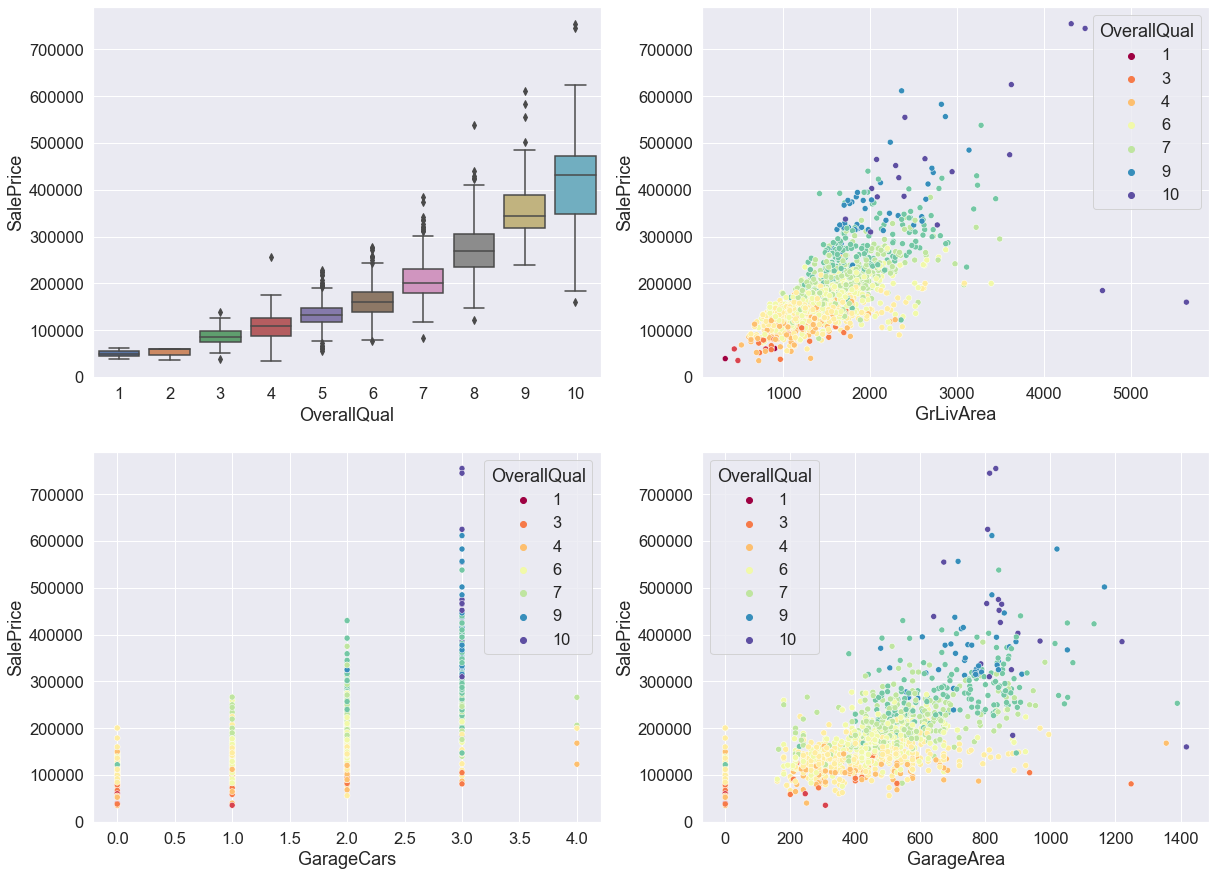

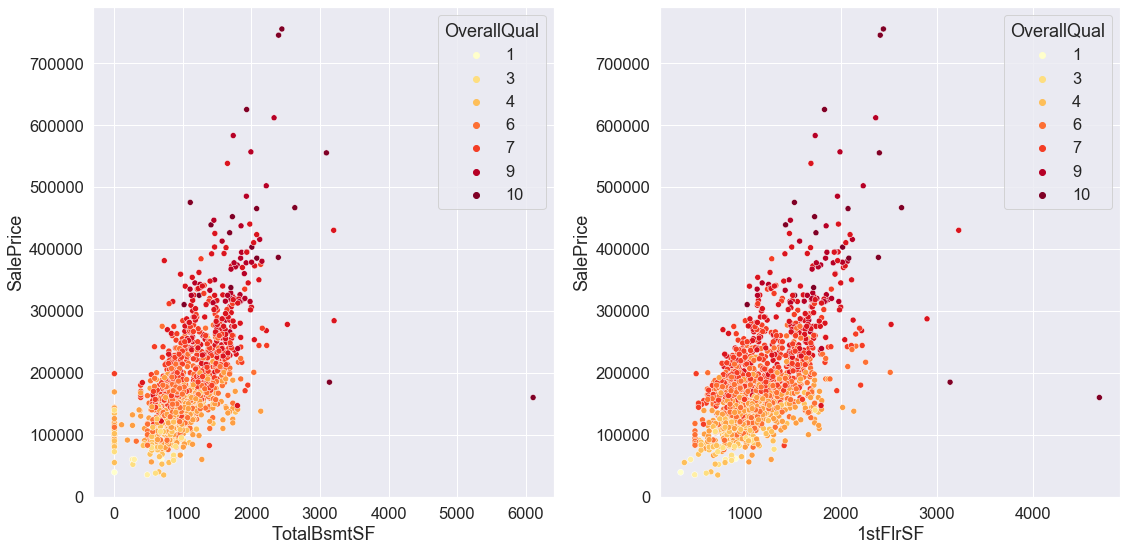

In [18]:
## Checking Quality of the data

fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

# (Corr= 0.817185) Box plot overallqual/salePrice
fig1 = fig.add_subplot(221); sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

# (Corr= 0.700927) GrLivArea vs SalePrice plot
fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.680625) GarageCars vs SalePrice plot
fig3 = fig.add_subplot(223); 
sns.scatterplot(x = train.GarageCars, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.650888) GarageArea vs SalePrice plot
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train.GarageArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig5 = plt.figure(figsize=(16, 8))
fig6 = fig5.add_subplot(121); 
sns.scatterplot(y = train.SalePrice , x = train.TotalBsmtSF, hue=train.OverallQual, palette= 'YlOrRd')

fig7 = fig5.add_subplot(122); 
sns.scatterplot(y = train.SalePrice, x = train['1stFlrSF'], hue=train.OverallQual, palette= 'YlOrRd')

plt.tight_layout(); plt.show()


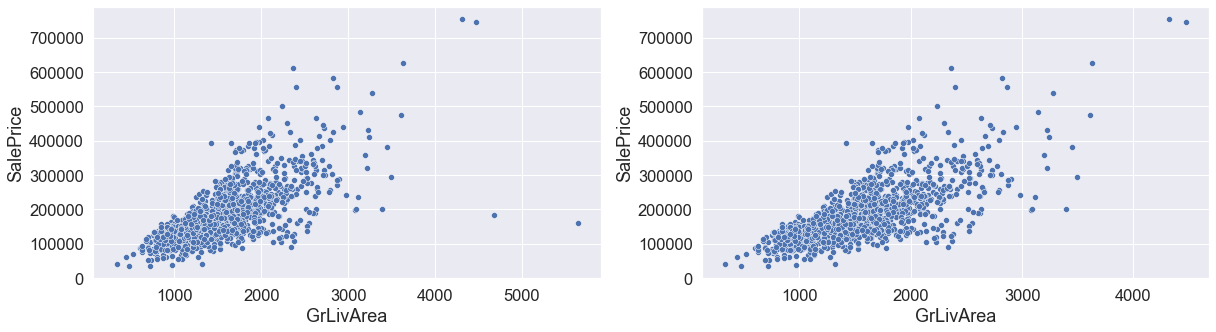

In [19]:
## Quality check

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, ax = ax)

#Deleting outliers
train = train.drop(train[(train.GrLivArea>4000) & (train.SalePrice<300000)].index)

#Check the graphic again
ax = fig.add_subplot(122)
sns.scatterplot(x =train.GrLivArea, y = train.SalePrice, ax = ax)
plt.show()

                                                                  Outliers: 1


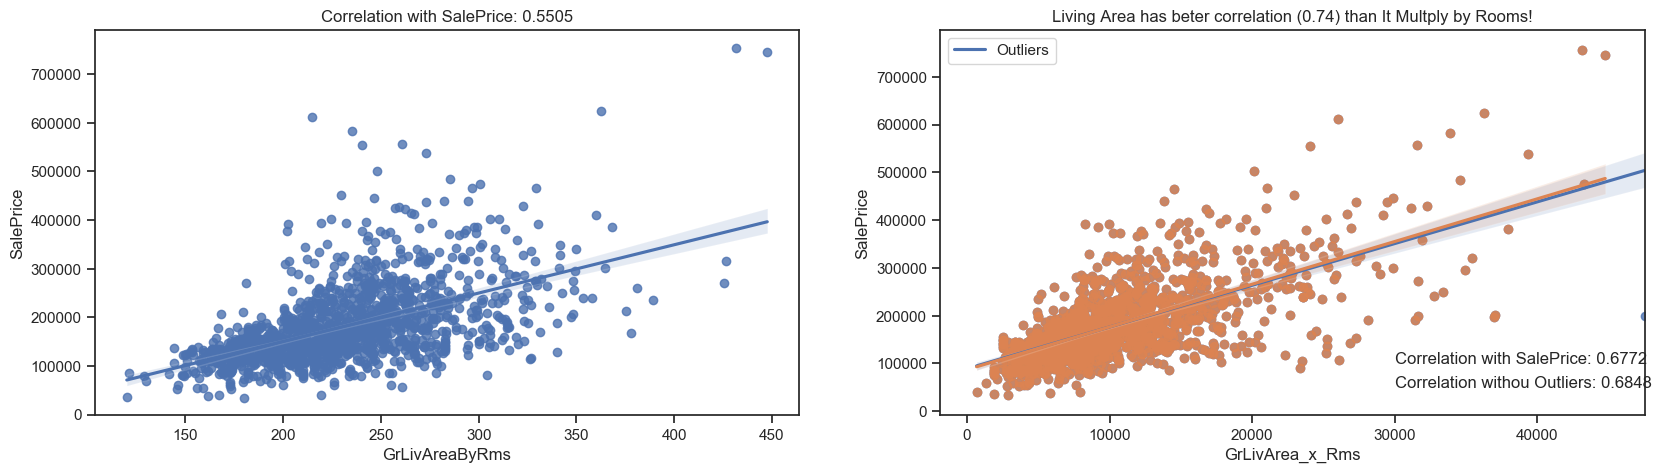

In [20]:
# Total Rooms above ground level and living area


sns.reset_defaults()
sns.set(style="ticks", color_codes=True)

df = train[['SalePrice', 'GrLivArea', 'TotRmsAbvGrd']]
df['GrLivAreaByRms'] = train.GrLivArea/train.TotRmsAbvGrd
df['GrLivArea_x_Rms'] = train.GrLivArea*train.TotRmsAbvGrd
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='GrLivAreaByRms', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GrLivAreaByRms.corr(df['SalePrice'])))
fig2 = fig.add_subplot(122); sns.regplot(x='GrLivArea_x_Rms', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=30000, y=100000, s='Correlation with SalePrice: {:1.4f}'.format(df.GrLivArea_x_Rms.corr(df['SalePrice'])))

print('                                                                  Outliers:',(df.GrLivArea_x_Rms>=45000).sum())
df = df.loc[df.GrLivArea_x_Rms<45000]
sns.regplot(x='GrLivArea_x_Rms', y='SalePrice', data=df); 
plt.title('Living Area has beter correlation ({:1.2f}) than It Multply by Rooms!'.format(df.GrLivArea.corr(df.SalePrice)))
plt.text(x=30000, y=50000, s='Correlation withou Outliers: {:1.4f}'.format(df.GrLivArea_x_Rms.corr(df['SalePrice'])))
plt.show()
del df

In [21]:
train = train[train.GrLivArea * train.TotRmsAbvGrd < 45000]
print('Train observations after remove outliers:',train.shape[0])

Train observations after remove outliers: 1457


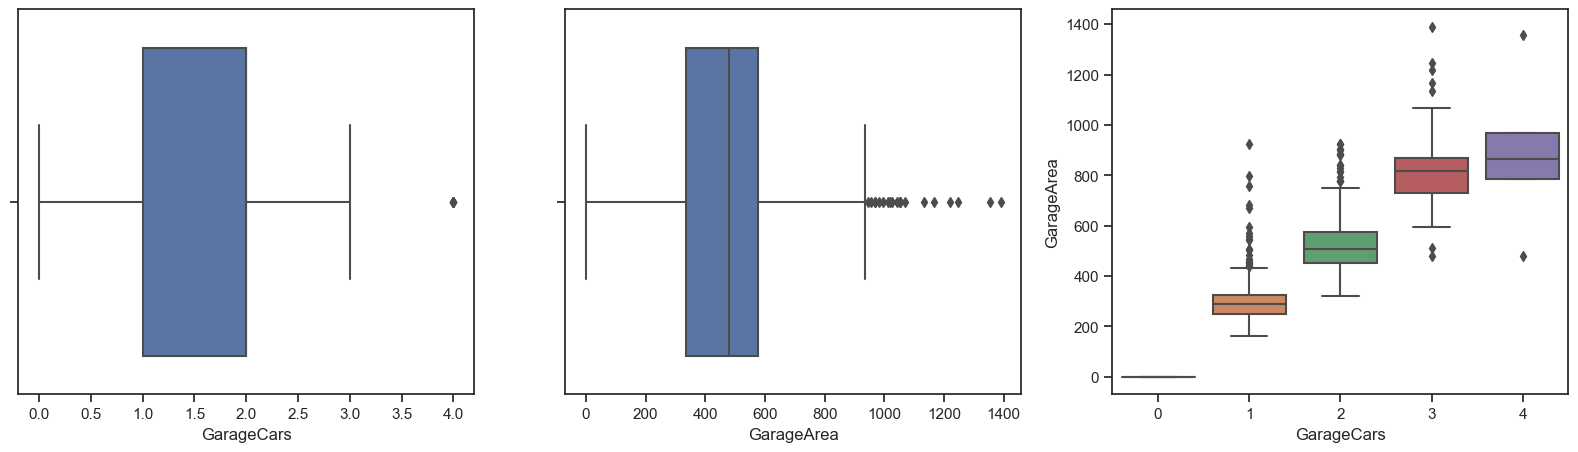

In [25]:
## Garage area and available cars space


fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(131); sns.boxplot(train.GarageCars)
fig2 = fig.add_subplot(132); sns.boxplot(train.GarageArea)
fig3 = fig.add_subplot(133); sns.boxplot(train.GarageCars, train.GarageArea)
plt.show()

                                                                 Outliers: 4


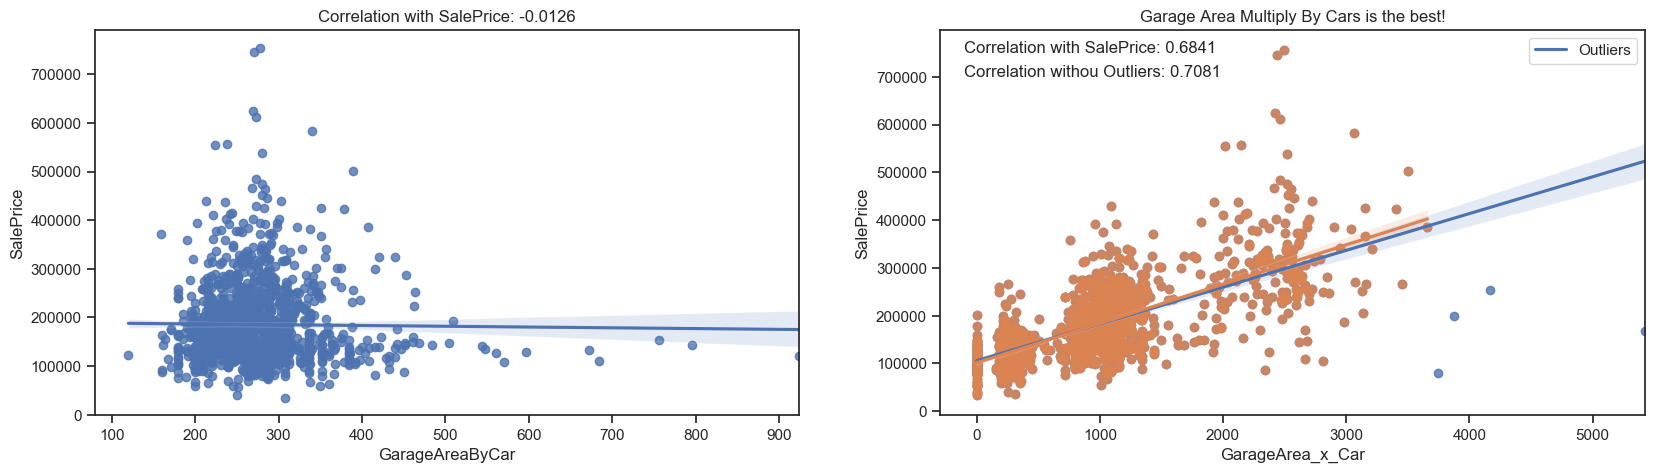

In [24]:

df = train[['SalePrice', 'GarageArea', 'GarageCars']]
df['GarageAreaByCar'] = train.GarageArea/train.GarageCars
df['GarageArea_x_Car'] = train.GarageArea*train.GarageCars

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='GarageAreaByCar', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GarageAreaByCar.corr(df['SalePrice'])))

fig2 = fig.add_subplot(122); sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=-100, y=750000, s='Correlation with SalePrice: {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))
print('                                                                 Outliers:',(df.GarageArea_x_Car>=3700).sum())
df = df.loc[df.GarageArea_x_Car<3700]
sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.title('Garage Area Multiply By Cars is the best!')
plt.text(x=-100, y=700000, s='Correlation withou Outliers: {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))
plt.show()
del df

In [26]:
train = train[train.GarageArea * train.GarageCars < 3700]
print('Total observatiosn after outliers cut:', train.shape[0])


Total observatiosn after outliers cut: 1453


                                                             Outliers: 1


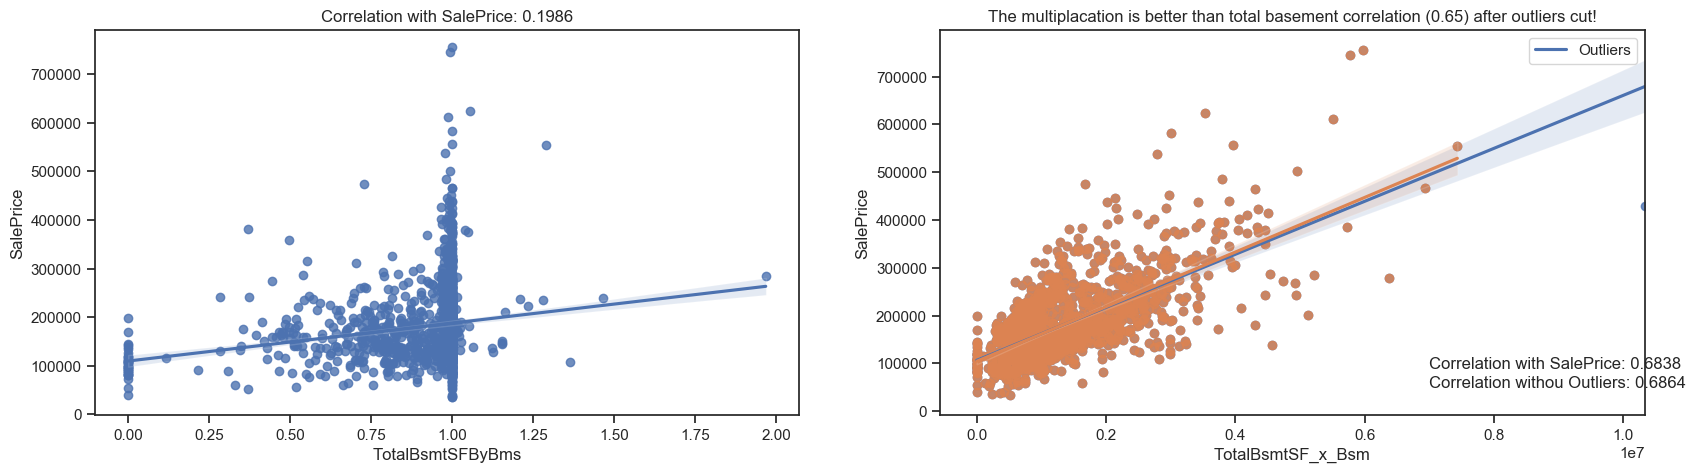

In [27]:
## Total Basement Area Vs 1st Floor Area

df = train[['SalePrice', 'TotalBsmtSF', '1stFlrSF']]
df['TotalBsmtSFByBms'] = train.TotalBsmtSF/train['1stFlrSF']
df['TotalBsmtSF_x_Bsm'] = train.TotalBsmtSF*train['1stFlrSF']
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='TotalBsmtSFByBms', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TotalBsmtSFByBms.corr(df['SalePrice'])))
fig2 = fig.add_subplot(122); sns.regplot(x='TotalBsmtSF_x_Bsm', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=7e06, y=90000, s='Correlation with SalePrice: {:1.4f}'.format(df.TotalBsmtSF_x_Bsm.corr(df['SalePrice'])))

print('                                                             Outliers:',(df.TotalBsmtSF_x_Bsm>=0.9e07).sum())
df = df.loc[df.TotalBsmtSF_x_Bsm<0.9e07]
sns.regplot(x='TotalBsmtSF_x_Bsm', y='SalePrice', data=df); 
plt.title('The multiplacation is better than total basement correlation ({:1.2f}) after outliers cut!'.format(df.TotalBsmtSF.corr(df.SalePrice)))
plt.text(x=7e06, y=50000, s='Correlation withou Outliers: {:1.4f}'.format(df.TotalBsmtSF_x_Bsm.corr(df['SalePrice'])))
plt.show()
del df


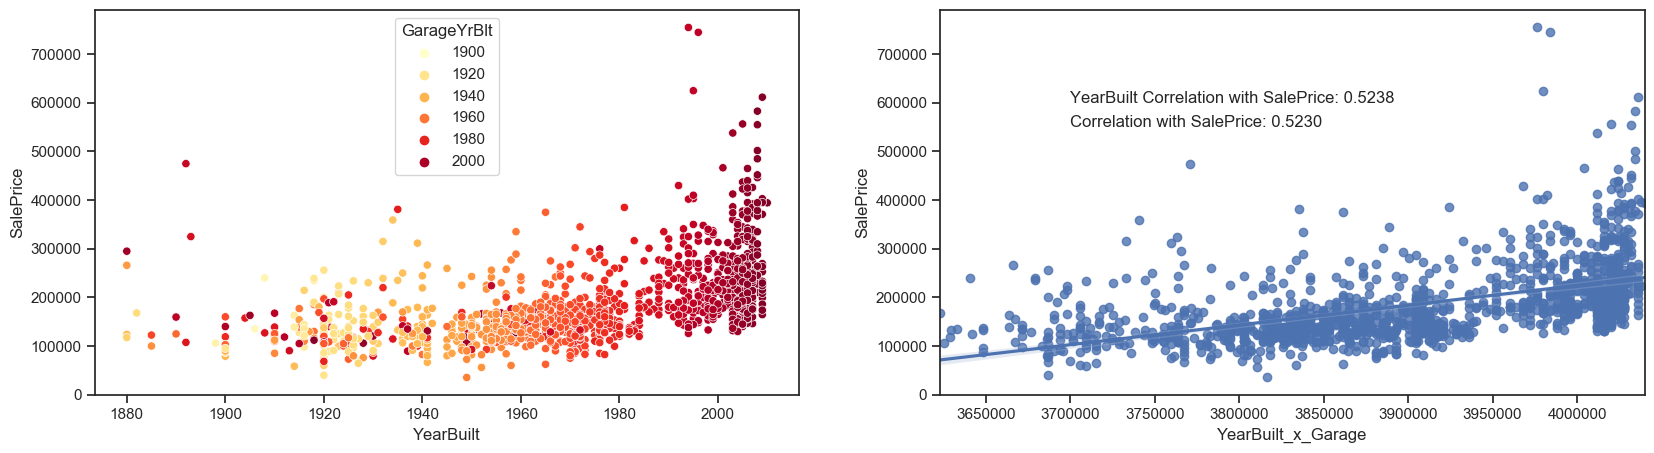

In [28]:
## Year Built Vs Garage Year Built

df = train[['SalePrice', 'YearBuilt', 'GarageYrBlt']]
df['YearBuilt_x_Garage'] = train.YearBuilt*train.GarageYrBlt
df['Garage_Newest'] = train.YearBuilt < train.GarageYrBlt

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.scatterplot(y = df.SalePrice, x = df.YearBuilt, hue=df.GarageYrBlt, palette= 'YlOrRd')
fig2 = fig.add_subplot(122); sns.regplot(x='YearBuilt_x_Garage', y='SalePrice', data=df); 
plt.text(x=3700000, y=600000, s='YearBuilt Correlation with SalePrice: {:1.4f}'.format(df.YearBuilt.corr(df['SalePrice'])))
plt.text(x=3700000, y=550000, s='Correlation with SalePrice: {:1.4f}'.format(df.YearBuilt_x_Garage.corr(df['SalePrice'])))
plt.show()

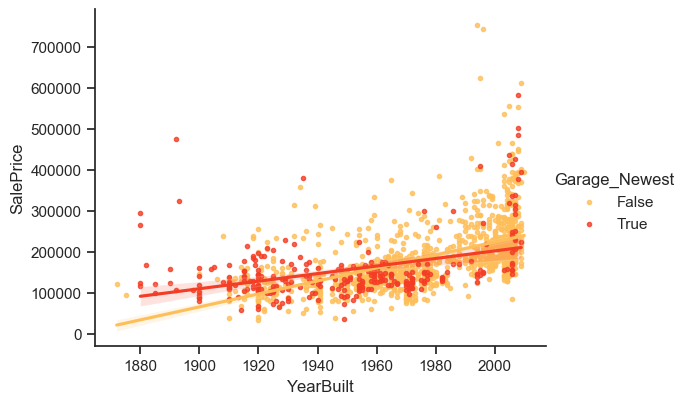

In [29]:
sns.lmplot(y = 'SalePrice', x = 'YearBuilt', data=df, markers='.', 
           aspect=1.4, height=4, hue= 'Garage_Newest', palette= 'YlOrRd')
plt.show();  
del df


Text(0.5, 1.0, 'Correlation with SalePrice: 0.2843')

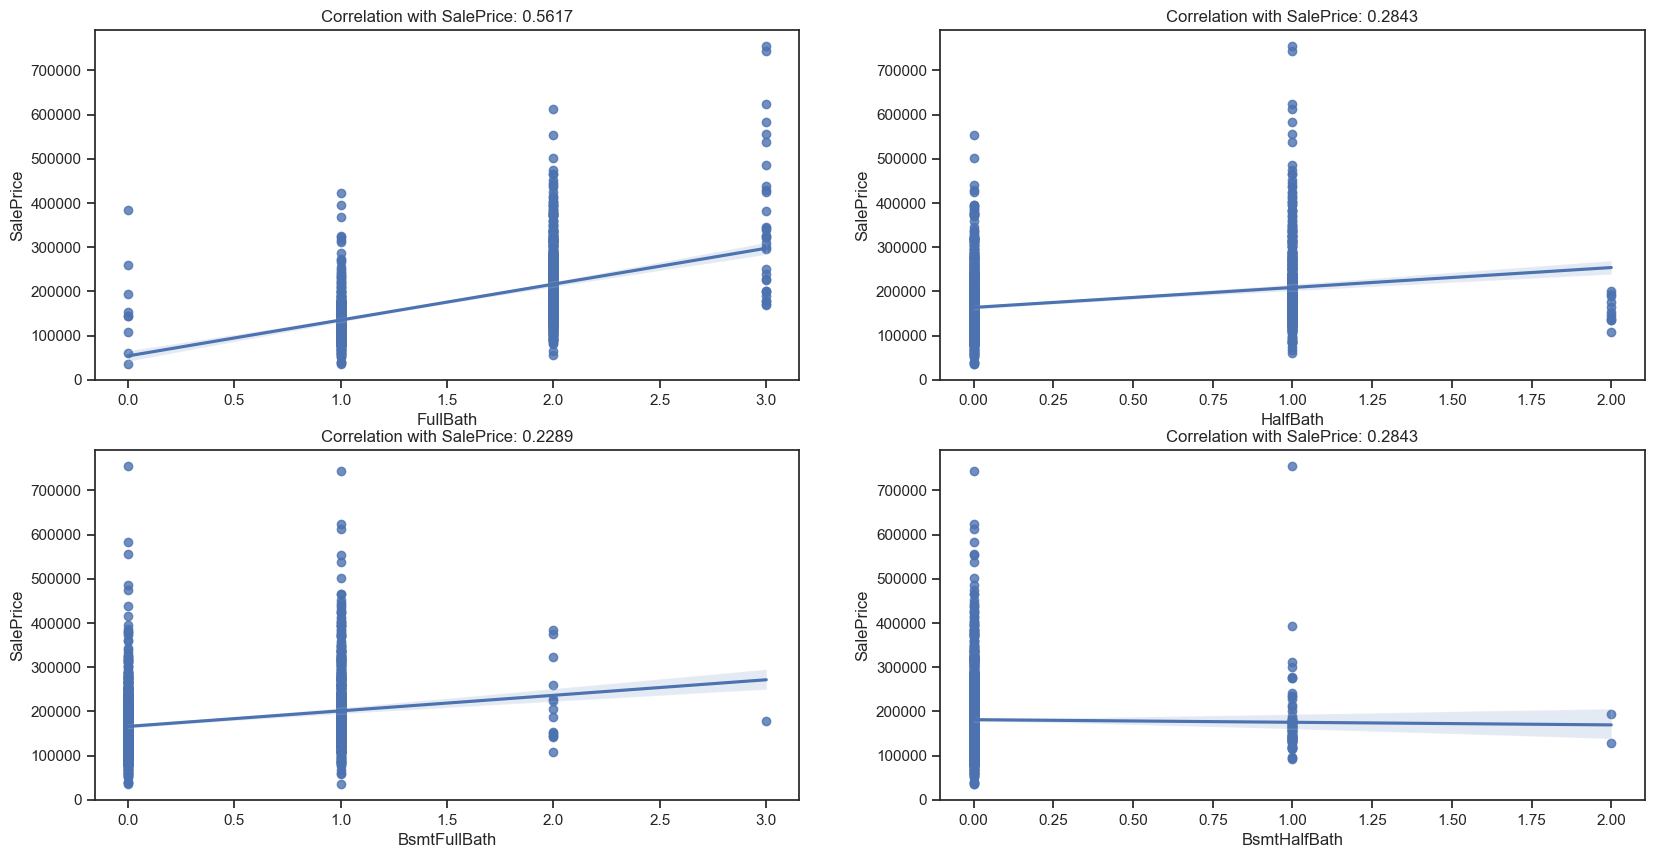

In [30]:
## Available bathrooms and their types


fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(221); sns.regplot(x='FullBath', y='SalePrice', data=train)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.FullBath.corr(train['SalePrice'])))

fig2 = fig.add_subplot(222); sns.regplot(x='HalfBath', y='SalePrice', data=train);
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

fig3 = fig.add_subplot(223); sns.regplot(x='BsmtFullBath', y='SalePrice', data=train)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.BsmtFullBath.corr(train['SalePrice'])))

fig4 = fig.add_subplot(224); sns.regplot(x='BsmtHalfBath', y='SalePrice', data=train);
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

In [32]:
df = train[['SalePrice', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']]
df['TotBathrooms'] = df.FullBath + (df.HalfBath*0.5) + df.BsmtFullBath + (df.BsmtHalfBath*0.5)

                                                                 Outliers: 2


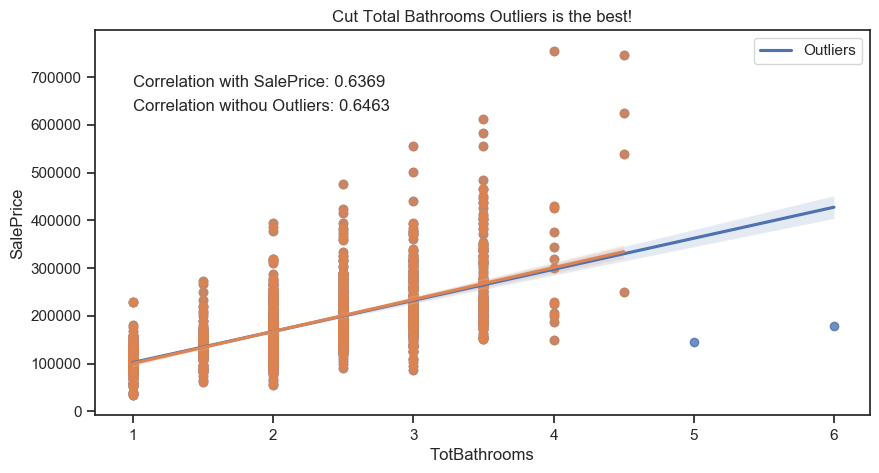

In [33]:
fig = plt.figure(figsize=(10,5))
sns.regplot(x='TotBathrooms', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=1, y=680000, s='Correlation with SalePrice: {:6.4f}'.format(df.TotBathrooms.corr(df['SalePrice'])))
print('                                                                 Outliers:',(df.TotBathrooms>=5).sum())
df = df.loc[df.TotBathrooms<5]
sns.regplot(x='TotBathrooms', y='SalePrice', data=df); plt.title('Cut Total Bathrooms Outliers is the best!')
plt.text(x=1, y=630000, s='Correlation withou Outliers: {:6.4f}'.format(df.TotBathrooms.corr(df['SalePrice'])))
plt.show()

In [34]:
train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]
print('Data observations after outliers deletion:', train.shape[0])

Data observations after outliers deletion: 1451


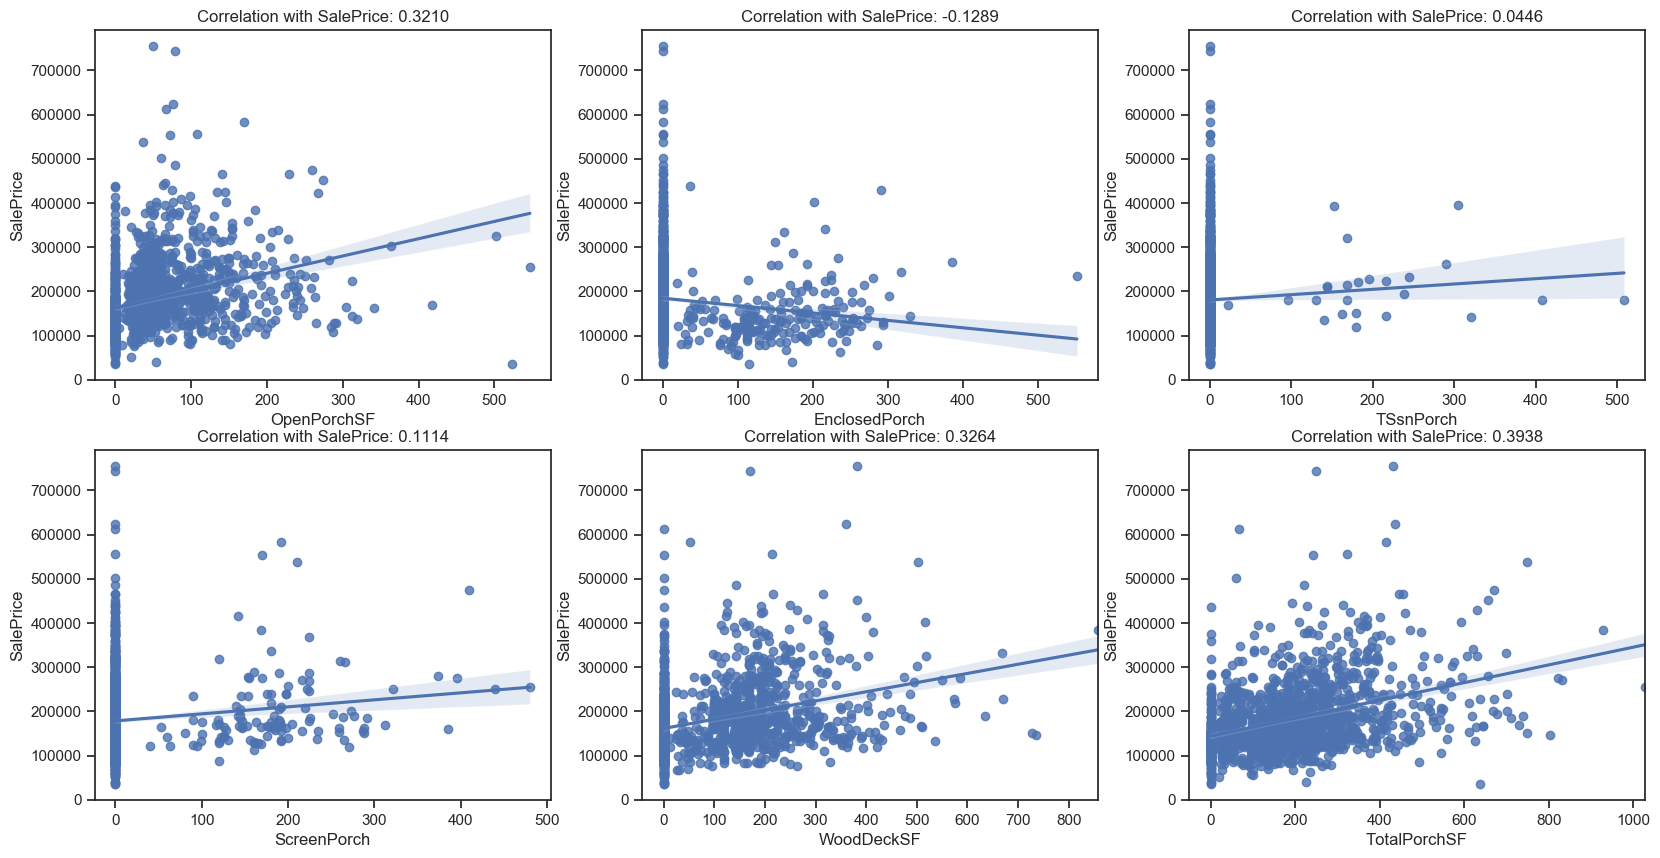

In [35]:
## Comparison with available Porch/Varanda features

def PorchPlots():
    fig = plt.figure(figsize=(20,10))
    fig1 = fig.add_subplot(231); sns.regplot(x='OpenPorchSF', y='SalePrice', data=df)
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.OpenPorchSF.corr(df['SalePrice'])))

    fig2 = fig.add_subplot(232); sns.regplot(x='EnclosedPorch', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.EnclosedPorch.corr(df['SalePrice'])))

    fig3 = fig.add_subplot(233); sns.regplot(x='TSsnPorch', y='SalePrice', data=df)
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TSsnPorch.corr(df['SalePrice'])))

    fig4 = fig.add_subplot(234); sns.regplot(x='ScreenPorch', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.ScreenPorch.corr(df['SalePrice'])))

    fig5 = fig.add_subplot(235); sns.regplot(x='WoodDeckSF', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.WoodDeckSF.corr(df['SalePrice'])))

    fig6 = fig.add_subplot(236); sns.regplot(x='TotalPorchSF', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TotalPorchSF.corr(df['SalePrice'])))

    plt.show()

df = train[['SalePrice', 'OpenPorchSF', 'EnclosedPorch', 'TSsnPorch', 'ScreenPorch', 'WoodDeckSF']]
df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df.TSsnPorch + df.ScreenPorch + df.WoodDeckSF
#df = df[df.TotalPorchSF<=600] # A possible outlier cut!
PorchPlots()

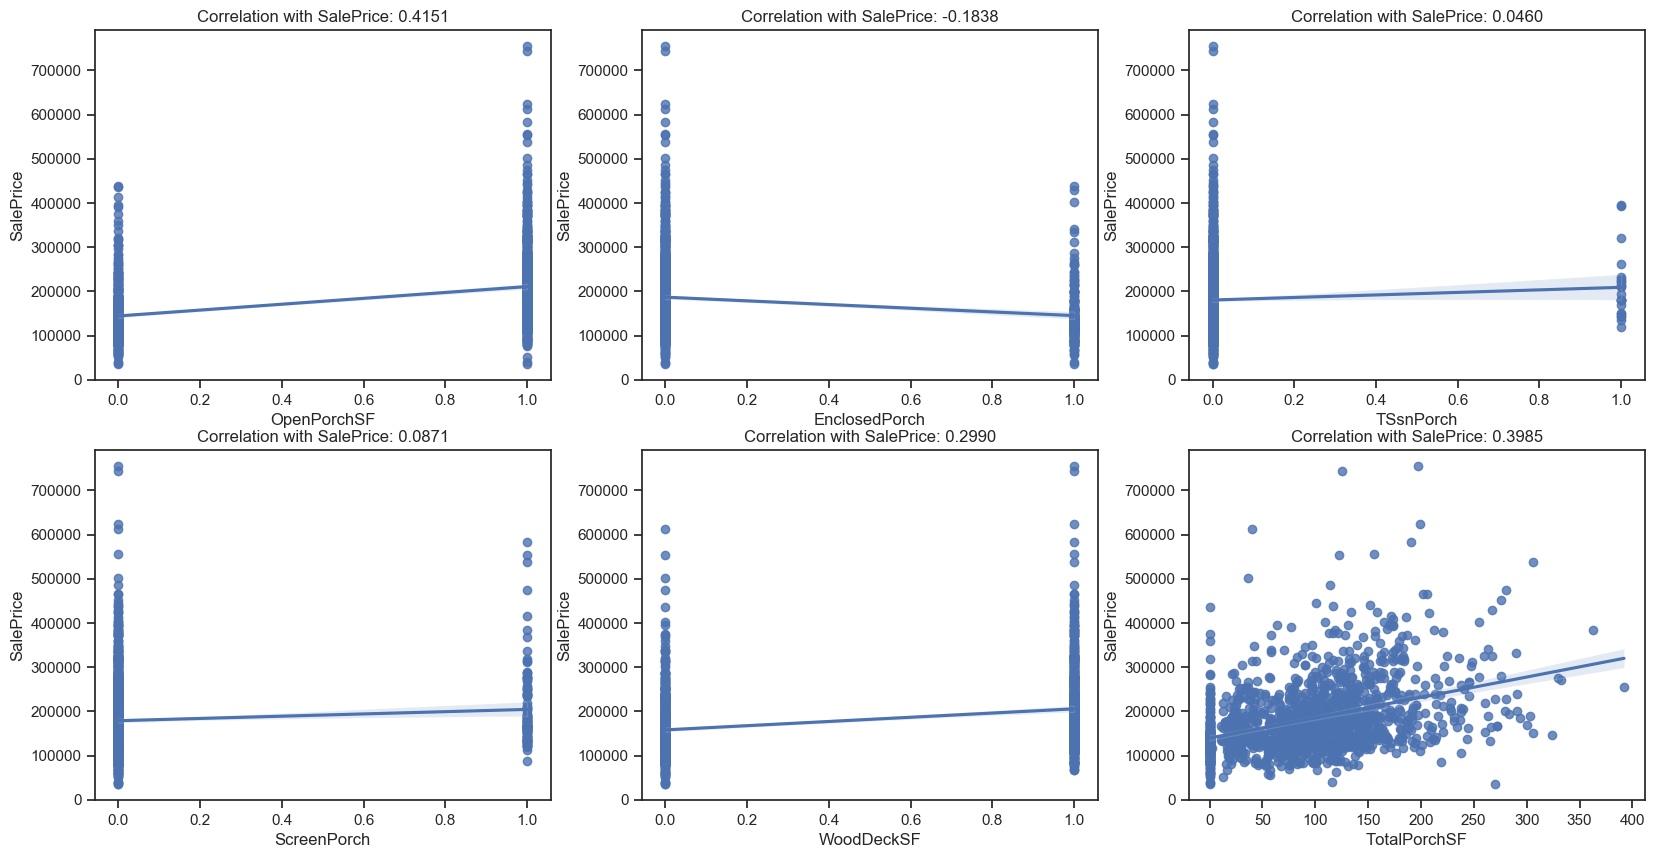

In [36]:
df.OpenPorchSF = df.OpenPorchSF > 0
df.EnclosedPorch =  df.EnclosedPorch > 0
df.TSsnPorch = df.TSsnPorch > 0
df.ScreenPorch = df.ScreenPorch > 0
df.WoodDeckSF = df.WoodDeckSF > 0
df.TotalPorchSF = np.sqrt(df.TotalPorchSF) * (np.log1p(np.sqrt(df.TotalPorchSF))**2)

PorchPlots()

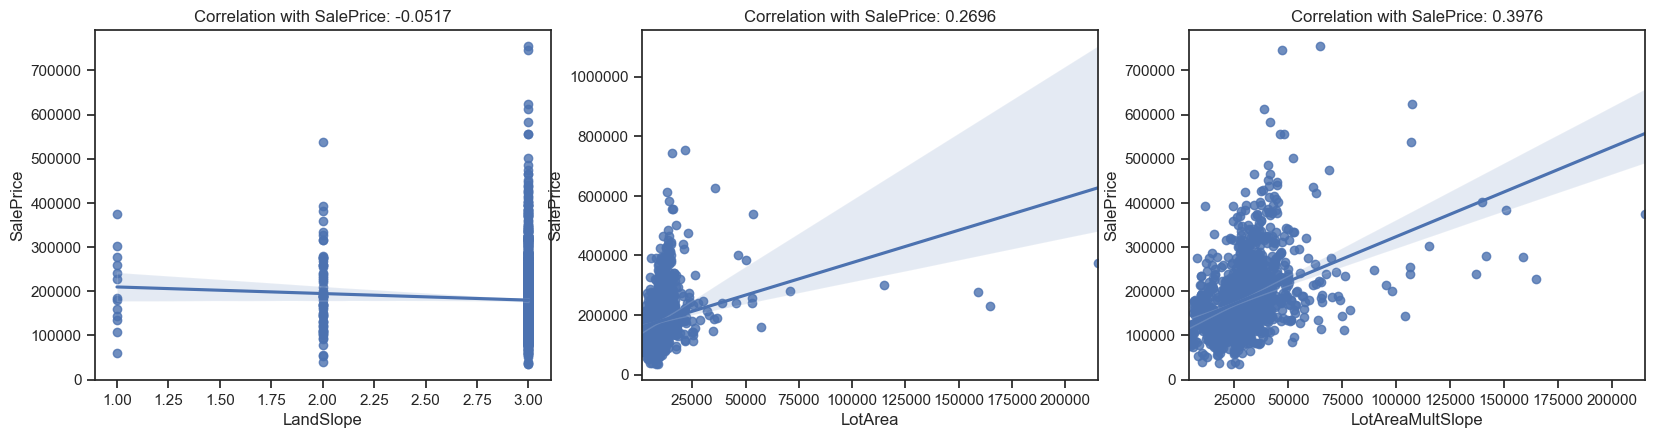

In [37]:
## Ladscape/Slope of the property

LandSlope = {}
LandSlope['Gtl'] = 3 #'Gentle slope'
LandSlope['Mod'] = 2 #'Moderate Slope'
LandSlope['Sev'] = 1 #'Severe Slope'

df = train[['SalePrice', 'LandSlope', 'LotArea']]
df.LandSlope = df.LandSlope.map(LandSlope)
df['LotAreaMultSlope'] = (df.LotArea * df.LandSlope)

fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(231); sns.regplot(x='LandSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LandSlope.corr(df['SalePrice'])))

fig2 = fig.add_subplot(232); sns.regplot(x='LotArea', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotArea.corr(df['SalePrice'])))

fig3 = fig.add_subplot(233); sns.regplot(x='LotAreaMultSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotAreaMultSlope.corr(df['SalePrice'])))
plt.show()

     SalePrice  LandSlope  LotArea  LotAreaMultSlope
249     277000          1   159000            159000
313     375000          1   215245            215245
335     228950          1   164660            164660


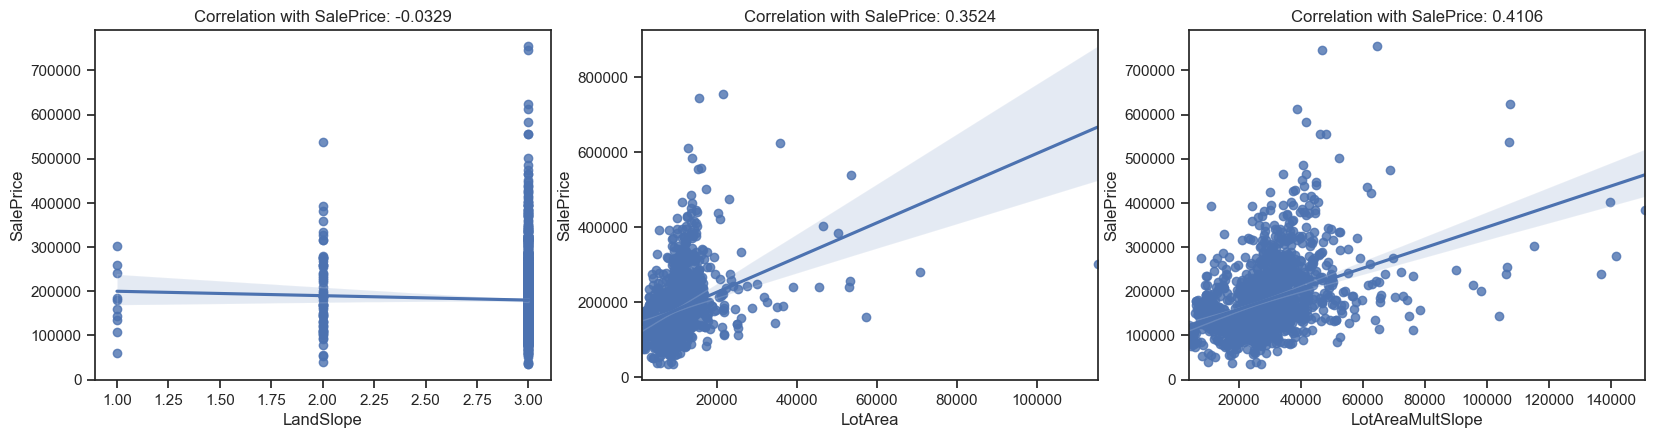

In [38]:
print(df[df.LotArea>155000])
df = df[df.LotArea<155000]
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(234); sns.regplot(x='LandSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LandSlope.corr(df['SalePrice'])))

fig2 = fig.add_subplot(235); sns.regplot(x='LotArea', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotArea.corr(df['SalePrice'])))

fig3 = fig.add_subplot(236); sns.regplot(x='LotAreaMultSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotAreaMultSlope.corr(df['SalePrice'])))
plt.show()

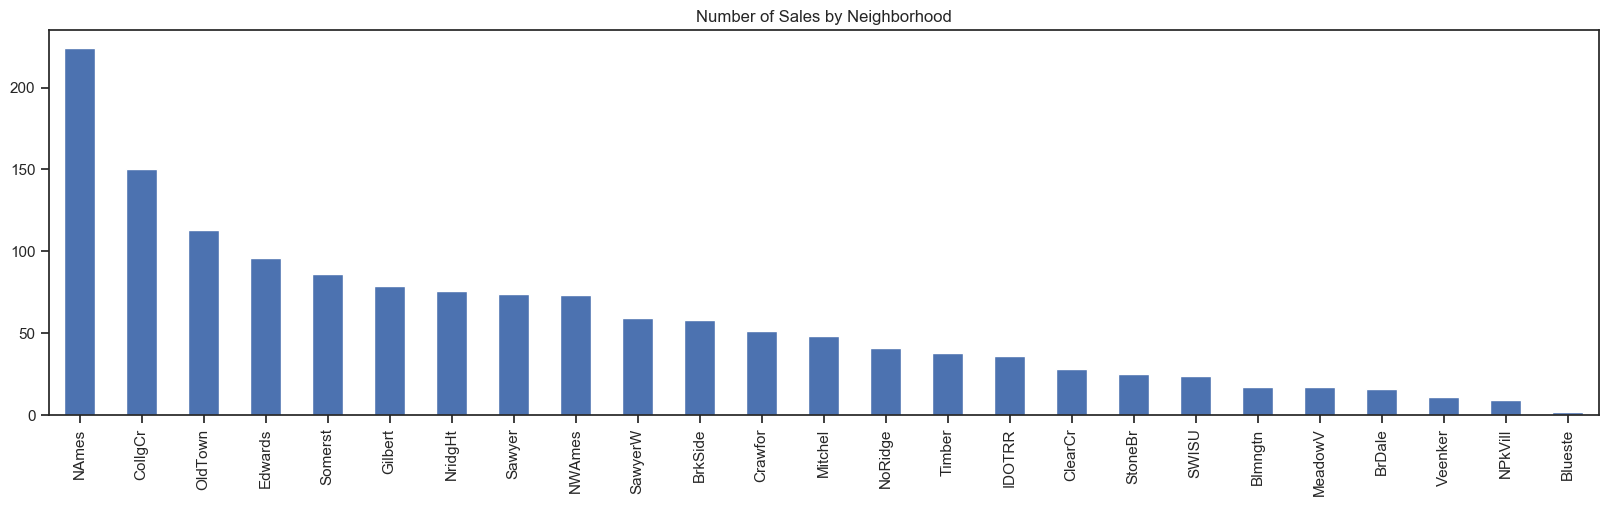

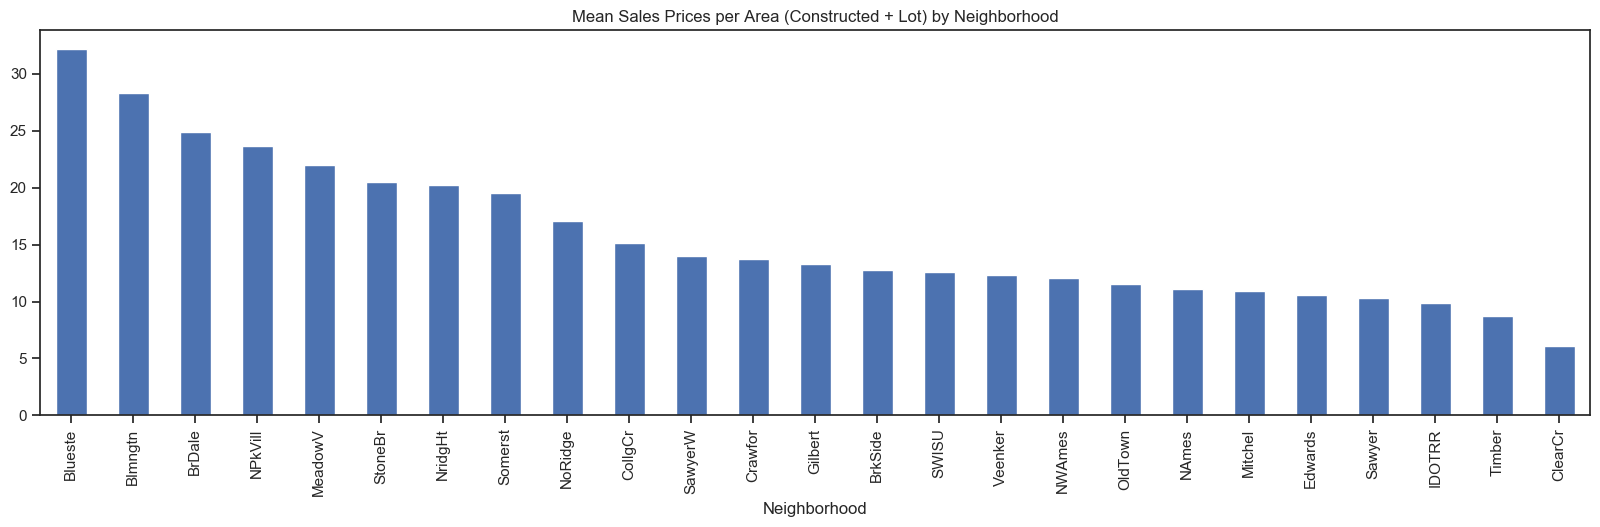

In [39]:
## Understanding impact of Neighbourhood


figa = plt.figure(figsize=(20, 5))
g = train.Neighborhood.value_counts().plot(kind='bar', title='Number of Sales by Neighborhood')

figb = plt.figure(figsize=(20, 5))
plt.tight_layout()
df = train[['SalePrice', 'YrSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )
 
df = df.groupby(by=['Neighborhood', 'YrSold'], as_index=False).sum()
Neig = df[['SalePrice', 'TotalArea', 'Neighborhood']].groupby(by='Neighborhood', as_index=False).sum()
Neig['NeigPrice'] = Neig.SalePrice / Neig.TotalArea
Neig.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)
g = Neig.groupby('Neighborhood').NeigPrice.sum().sort_values(ascending = False).\
    plot(kind='bar', title='Mean Sales Prices per Area (Constructed + Lot) by Neighborhood')
Neig = Neig.groupby(by='Neighborhood', as_index=True).NeigPrice.sum().sort_values(ascending = False)

                              Yearly Sales Prices per Area (Constructed + Lot) by Neighborhood:


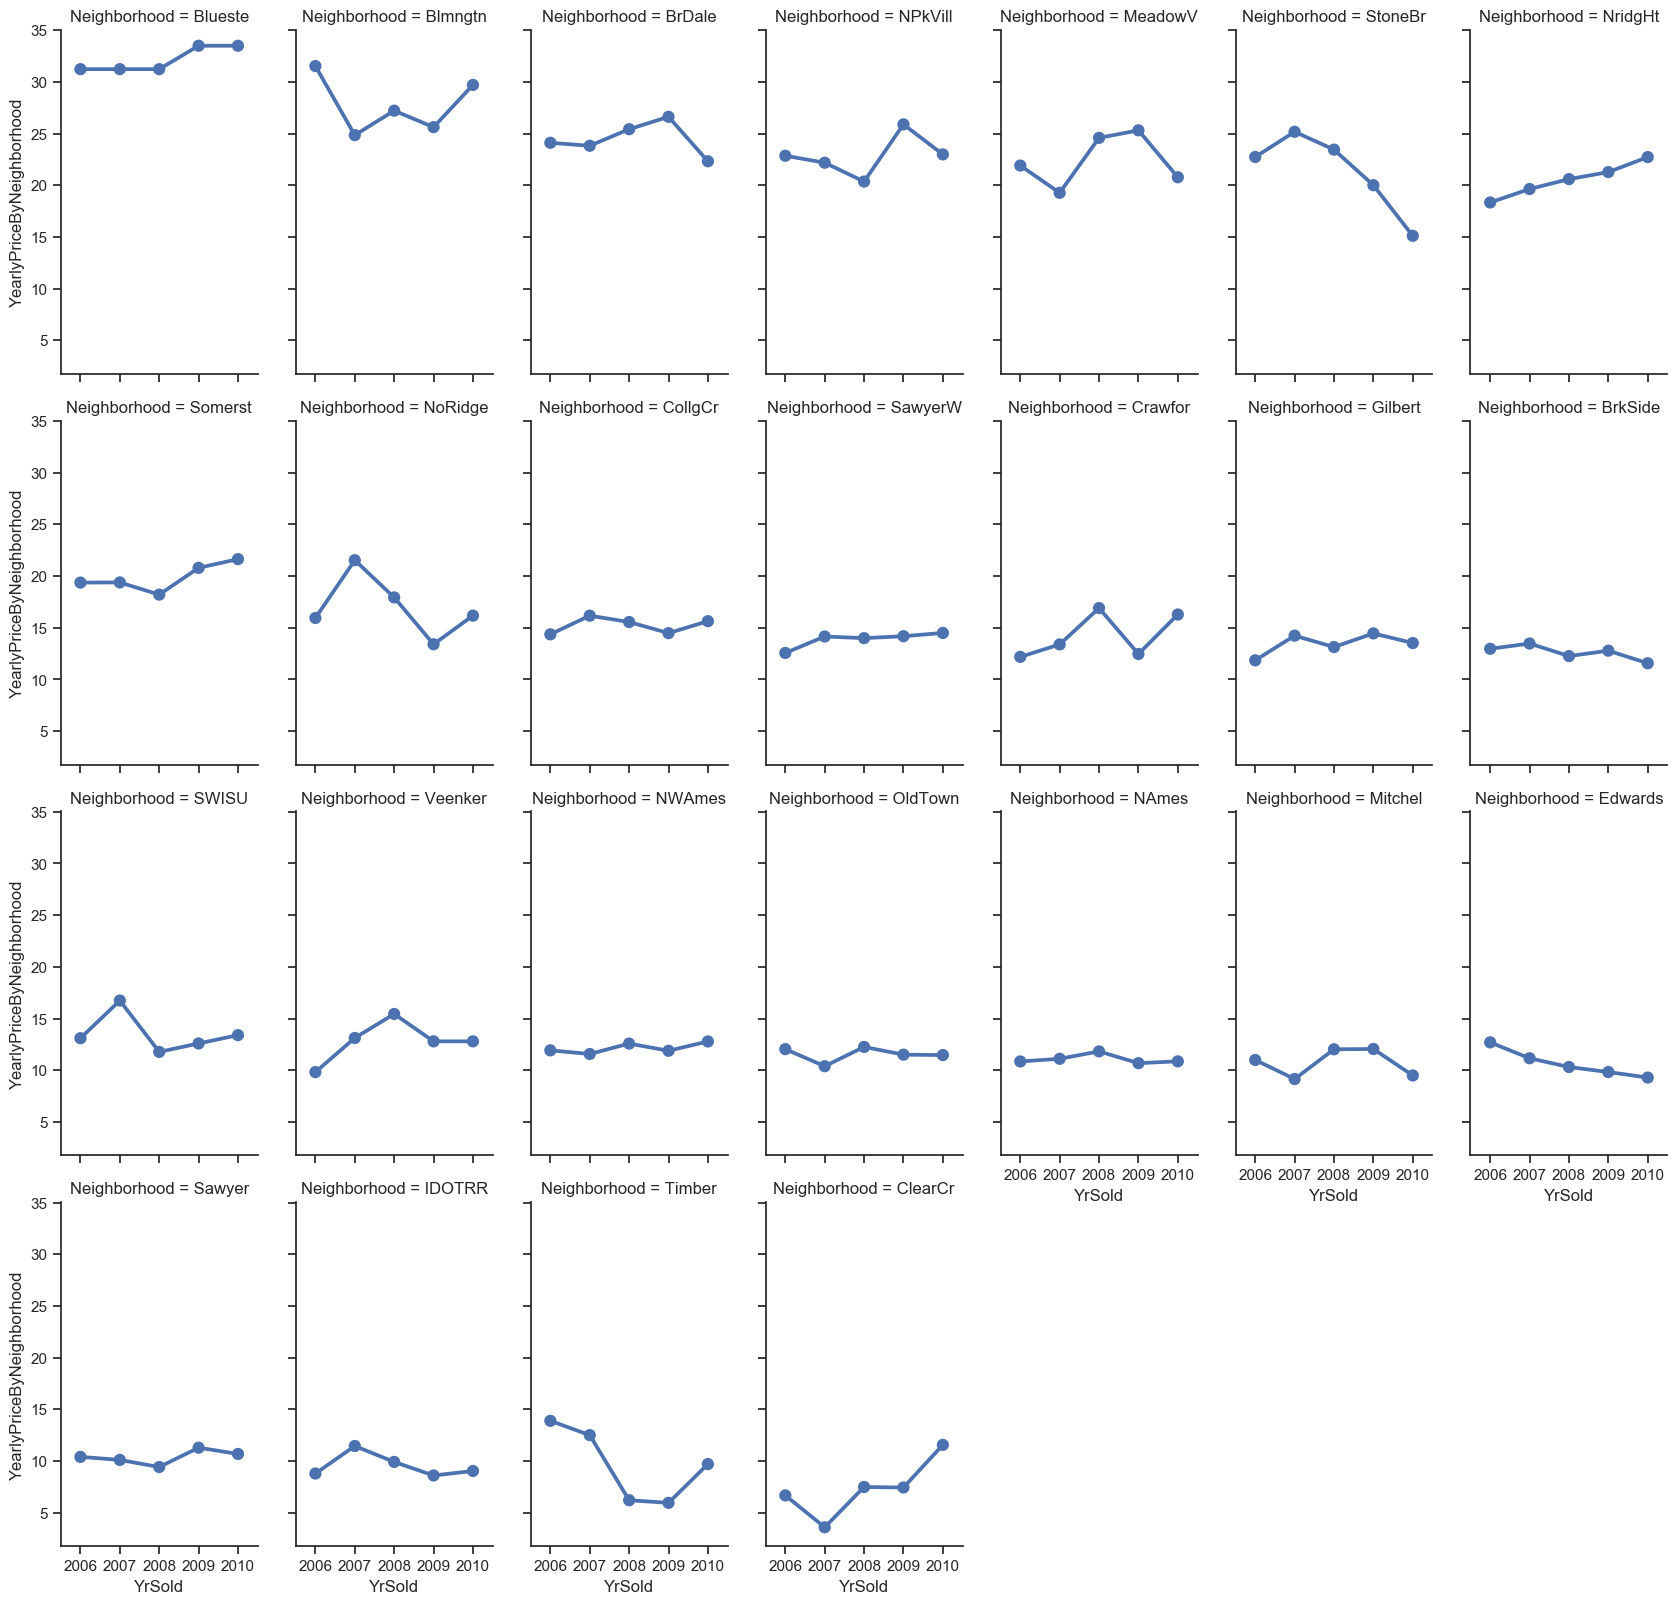

In [40]:
# Yearly Sales Price per Area (Constructed + Lot) by Neighborhood:

df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea
df.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)

# Fill the gaps
df = df.append(pd.DataFrame([['NPkVill', 2006, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Veenker', 2009, df.HistPriceByNeighborhood[df.Neighborhood=='Veenker'].mean()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Veenker', 2010, df.HistPriceByNeighborhood[df.Neighborhood=='Veenker'].mean()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Blueste', 2006, df.HistPriceByNeighborhood[df.Neighborhood=='Blueste'].min()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Blueste', 2007, df.HistPriceByNeighborhood[df.Neighborhood=='Blueste'].min()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Blueste', 2010, df.HistPriceByNeighborhood[df.Neighborhood=='Blueste'].max()]], 
                            columns=df.columns))

# Reserve data to merge with all data set of train and test data
YearlyPrice = df
YearlyPrice.columns = ['Neighborhood', 'YrSold', 'YearlyPriceByNeighborhood']

print('                              Yearly Sales Prices per Area (Constructed + Lot) by Neighborhood:')
g = sns.catplot(y= 'YearlyPriceByNeighborhood', x = 'YrSold', col='Neighborhood', data=YearlyPrice, 
               kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index)


                                 Monthly Sales Prices per Area (Constructed + Lot) by Neighborhood:


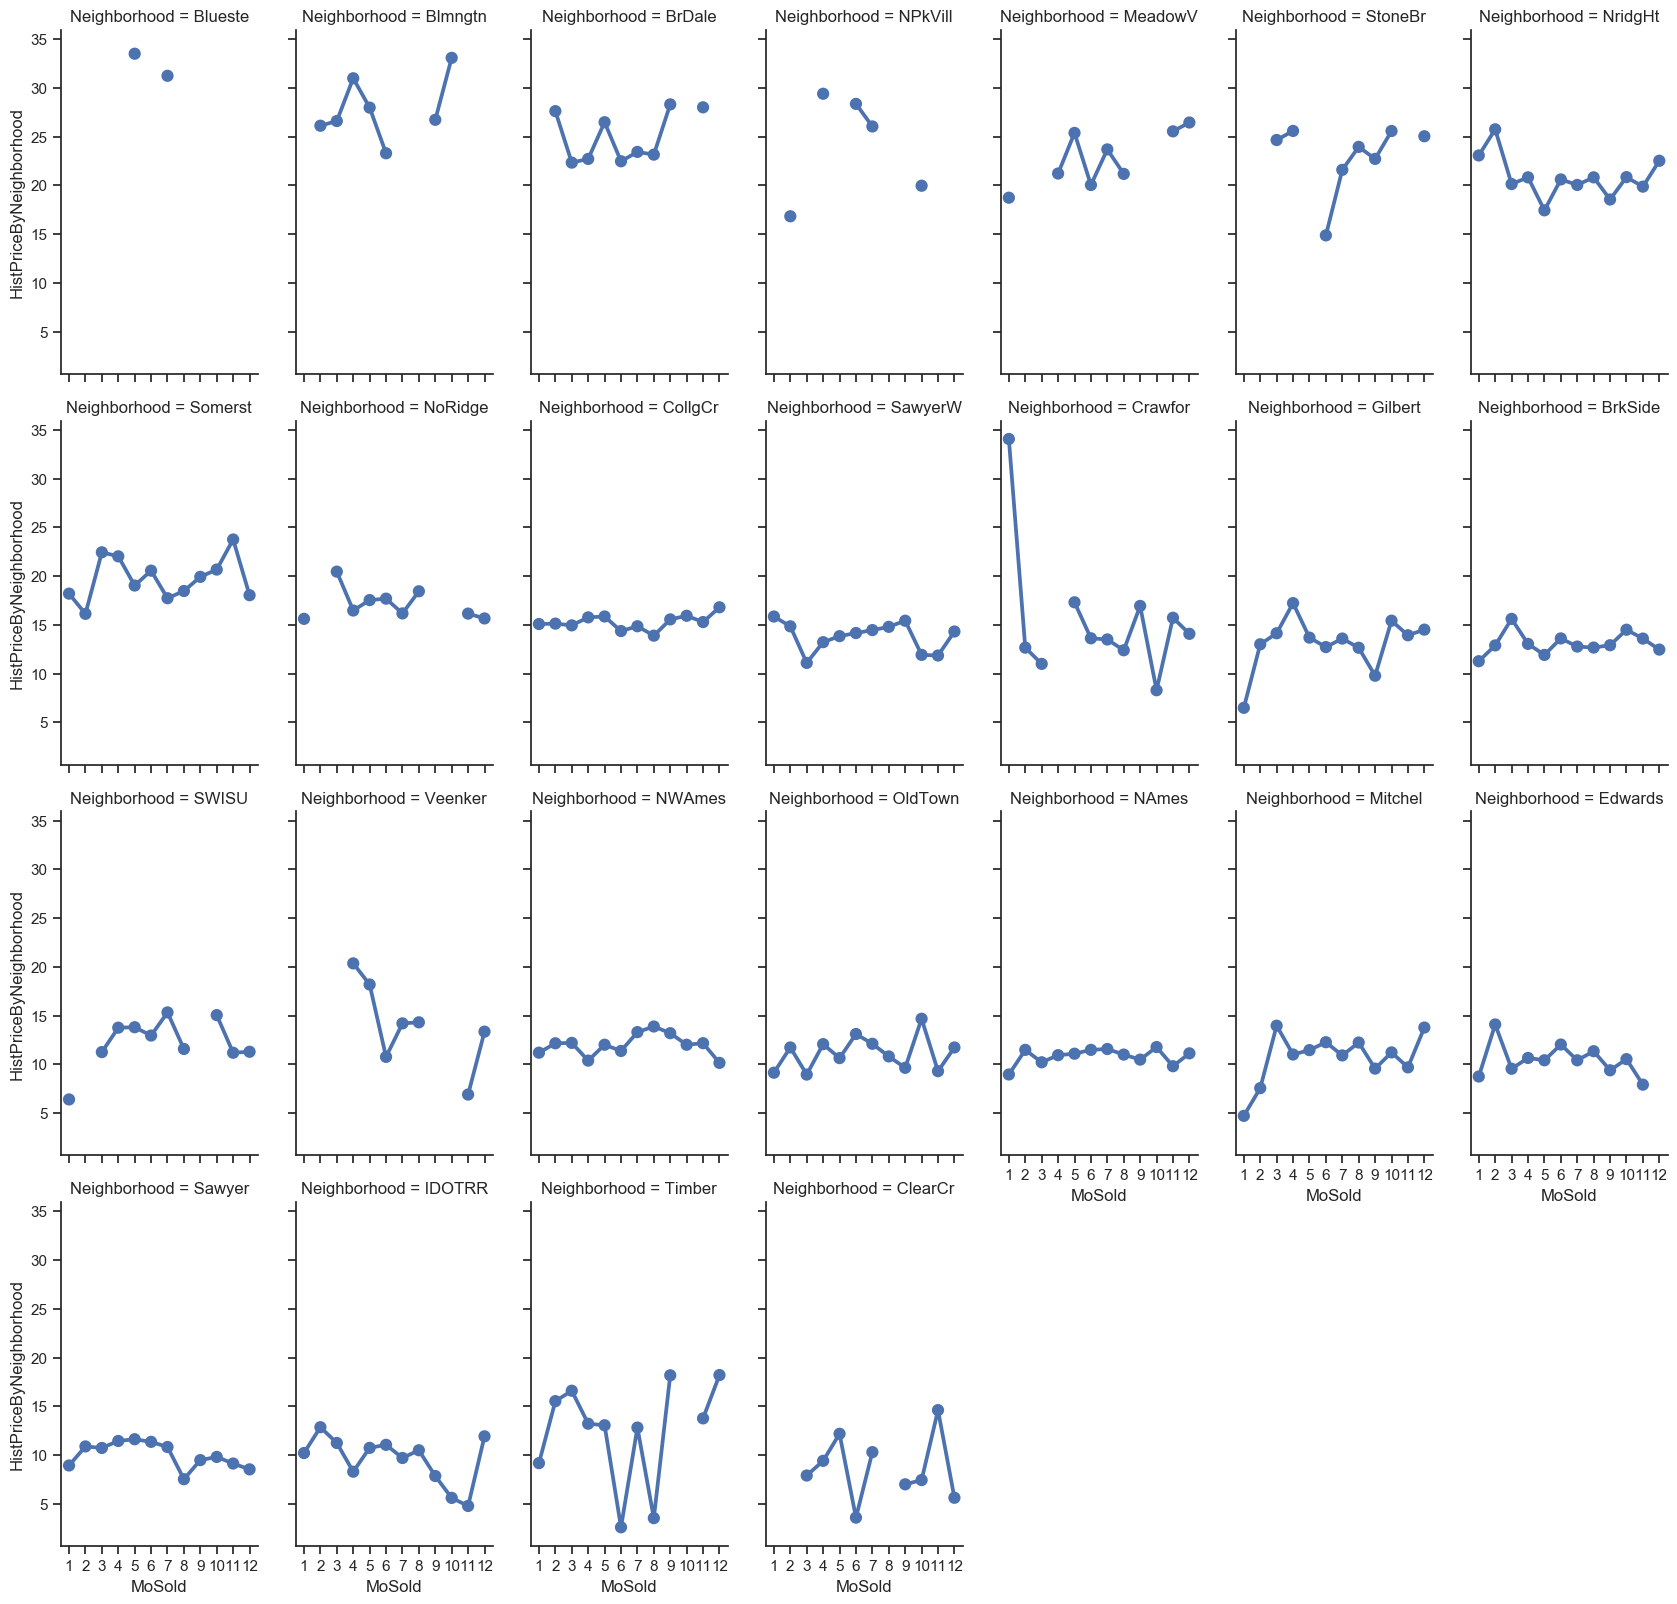

In [41]:
# Monthly Sales Prices per Area (Constructed + Lot) by Neighborhood:
df = train[['SalePrice', 'MoSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )

df = df.groupby(by=['Neighborhood', 'MoSold'], as_index=False).sum()
df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea
df.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)

print('                                 Monthly Sales Prices per Area (Constructed + Lot) by Neighborhood:')
g = sns.catplot(y= 'HistPriceByNeighborhood', x = 'MoSold', col='Neighborhood', data=df, 
               kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index )

In [42]:
# Outliers from Crawfor Neighborhood
df = train[train.Neighborhood=='Crawfor'][['SalePrice', 'MoSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )

df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea
df[df.HistPriceByNeighborhood>30]

,SalePrice,MoSold,Neighborhood,TotalArea,HistPriceByNeighborhood
1181,392500,11,Crawfor,9875.000,39.747
1405,275000,1,Crawfor,8074.000,34.060


In [43]:
train = train.loc[~(train.SalePrice==392500.0)]
train = train.loc[~((train.SalePrice==275000.0) & (train.Neighborhood=='Crawfor'))]
print('Data observations after outliers deletion:', train.shape[0])

Data observations after outliers deletion: 1449


In [44]:
# Bin neighborhood for trade cases with low observations on monthly sales prices per Area (Constructed + Lot) by Neighborhood:
Neigb = {}
Neigb['Blueste'] = 'Top'     # 32.212721
Neigb['Blmngtn'] = 'Top'     # 28.364756
Neigb['BrDale']  = 'BrDale'  # 24.903923
Neigb['NPkVill'] = 'NPkVill' # 23.681105
Neigb['MeadowV'] = 'High'    # 22.034923
Neigb['StoneBr'] = 'High'    # 20.475090
Neigb['NridgHt'] =  'High'   # 20.209245
Neigb['Somerst'] = 'Somerst' # 19.551888
Neigb['NoRidge'] = 'NoRidge' # 17.038145
Neigb['CollgCr'] = 'CollgCr' # 15.134767
Neigb['SawyerW'] = 'SawyerW' # 13.992995
Neigb['Crawfor'] = 'Crawfor' # 13.773418
Neigb['Gilbert'] = 'Gilbert' # 13.260281
Neigb['BrkSide'] = 'BrkSide' # 12.785202
Neigb['SWISU']   = 'SVN'     # 12.635171
Neigb['Veenker'] = 'SVN'     # 12.343735
Neigb['NWAmes']  = 'SVN'     # 12.066590
Neigb['OldTown'] = 'OldTown' # 11.571331
Neigb['NAmes']   = 'NAmes'   # 11.091393
Neigb['Mitchel'] = 'Mitchel' # 10.936368
Neigb['Edwards'] = 'Edwards' # 10.614919
Neigb['Sawyer']  = 'Sawyer'  #10.334445
Neigb['IDOTRR']  = 'IDOTRR'  # 9.880838
Neigb['Timber']  = 'Timber'  # 8.723326
Neigb['ClearCr'] = 'ClearCr' # 6.113654

In [45]:
# Preper dataset for Sales Price per Area (Constructed + Lot) by Neighborhood:
df = train[['SalePrice', 'MoSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )
df['Price'] = df.SalePrice/df.TotalArea

# Cut Outliers from Crawfor Neighborhood
df = df[(((df.Neighborhood == 'Crawfor') & (df.Price<30.)) | (df.Neighborhood != 'Crawfor'))]
df.drop(['Price'], axis=1, inplace=True)

df.Neighborhood = train.Neighborhood.map(Neigb)

df = df.groupby(by=['Neighborhood', 'MoSold'], as_index=False).sum()
df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea

# Get the index for order by value
Neig = df[['SalePrice', 'TotalArea', 'Neighborhood']].groupby(by='Neighborhood', as_index=False).sum()
Neig['NeigPrice'] = Neig.SalePrice / Neig.TotalArea
Neig.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)
Neig = Neig.groupby(by='Neighborhood', as_index=True).NeigPrice.sum().sort_values(ascending = False)

df.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)

# Fill the gaps
df = df.append(pd.DataFrame([['Top', 1, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Top', 8, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Top', 11, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Top', 12, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['BrDale', 1, df.HistPriceByNeighborhood[df.Neighborhood=='BrDale'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['BrDale', 10, df.HistPriceByNeighborhood[df.Neighborhood=='BrDale'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['BrDale', 12, df.HistPriceByNeighborhood[df.Neighborhood=='BrDale'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 1, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 3, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 5, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 8, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 9, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 11, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 12, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NoRidge', 2, df.HistPriceByNeighborhood[df.Neighborhood=='NoRidge'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NoRidge', 9, df.HistPriceByNeighborhood[df.Neighborhood=='NoRidge'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NoRidge', 10, df.HistPriceByNeighborhood[df.Neighborhood=='NoRidge'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Crawfor', 1, df.HistPriceByNeighborhood[df.Neighborhood=='Crawfor'].max()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Crawfor', 4, df.HistPriceByNeighborhood[df.Neighborhood=='Crawfor'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Timber', 10, df.HistPriceByNeighborhood[df.Neighborhood=='Timber'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['ClearCr', 1, df.HistPriceByNeighborhood[df.Neighborhood=='ClearCr'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['ClearCr', 2, df.HistPriceByNeighborhood[df.Neighborhood=='ClearCr'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['ClearCr', 8, df.HistPriceByNeighborhood[df.Neighborhood=='ClearCr'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Edwards', 12, df.HistPriceByNeighborhood[df.Neighborhood=='Edwards'].mean()]], 
                            columns=df.columns))

                         Monthly Hist Sales Prices per Area (Construct + Lot) by Neighborhood:


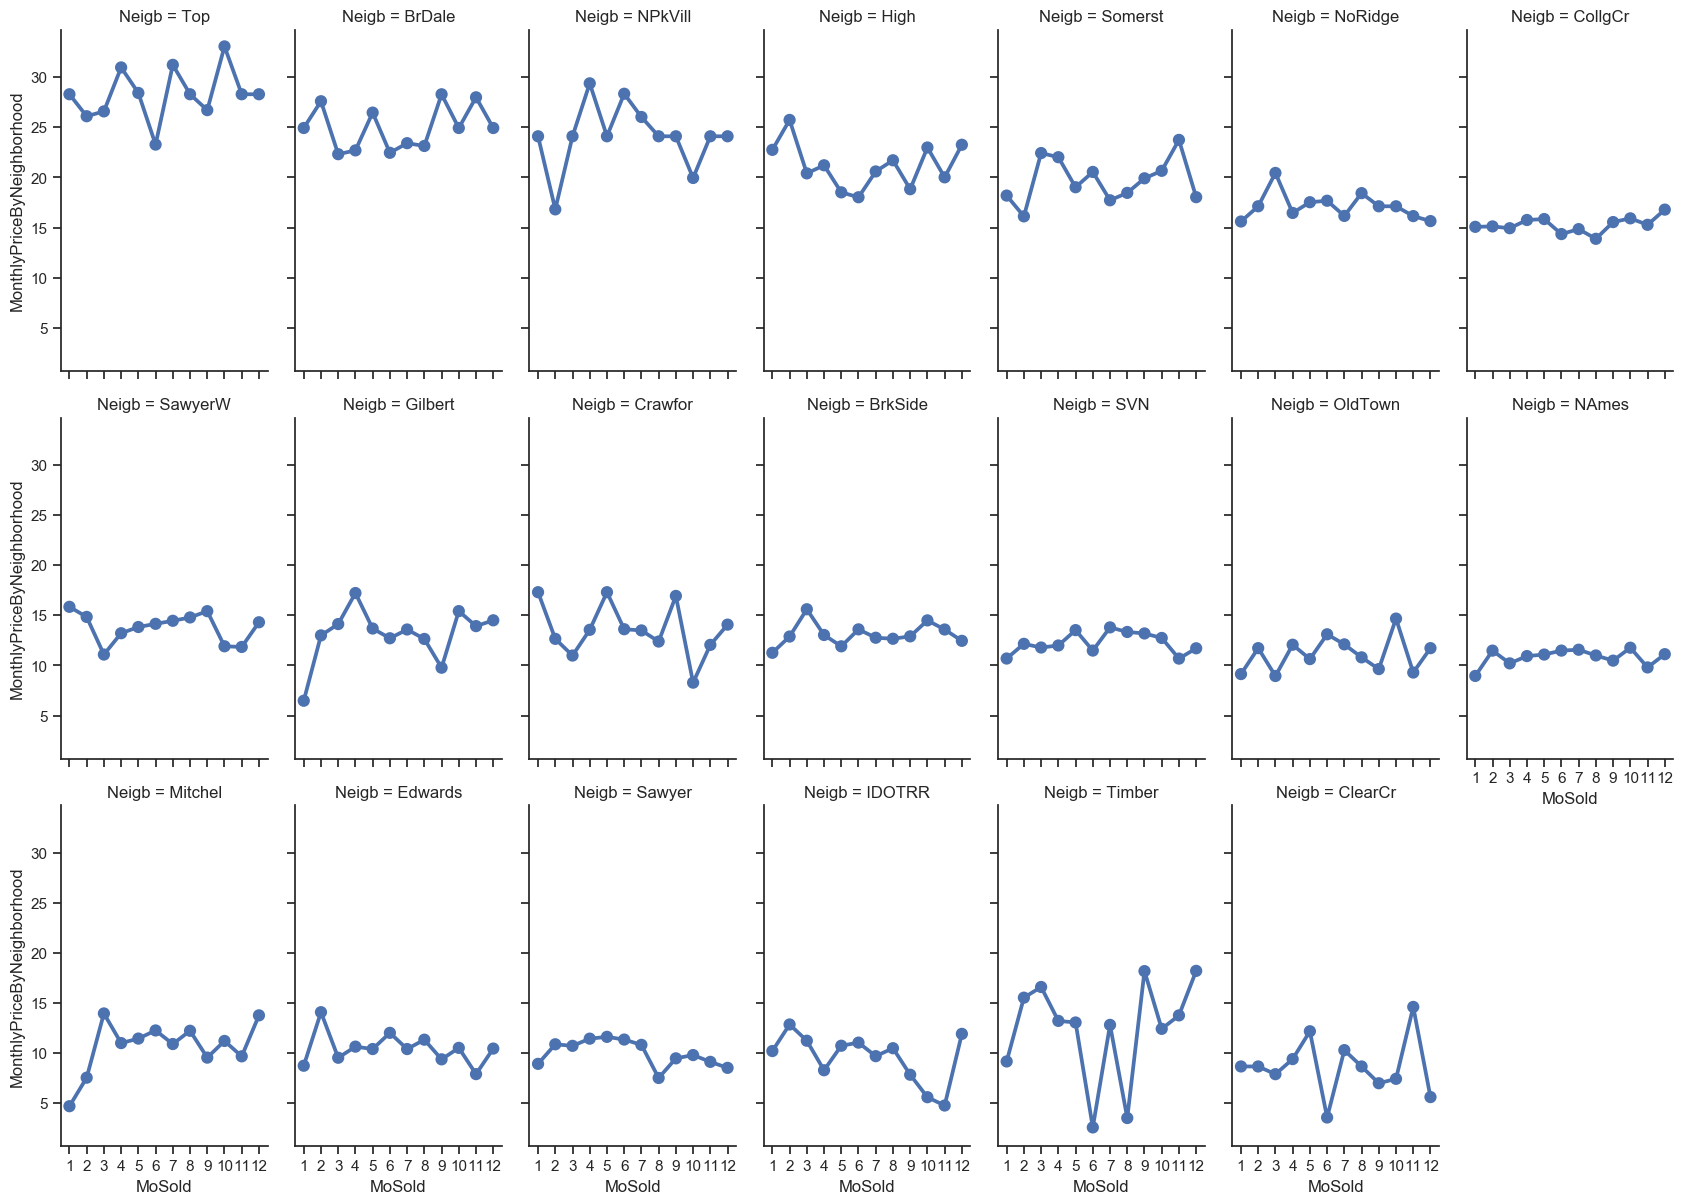

In [46]:
# Reserve data to merge with all data set of train and test data
MonthlyPrice = df
MonthlyPrice.columns = ['Neigb', 'MoSold', 'MonthlyPriceByNeighborhood']

print('                         Monthly Hist Sales Prices per Area (Construct + Lot) by Neighborhood:')
g = sns.catplot(y= 'MonthlyPriceByNeighborhood', x = 'MoSold', col='Neigb', data=MonthlyPrice, 
               kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index )


In [47]:
## Checking dependent variables vs Saleprice

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()


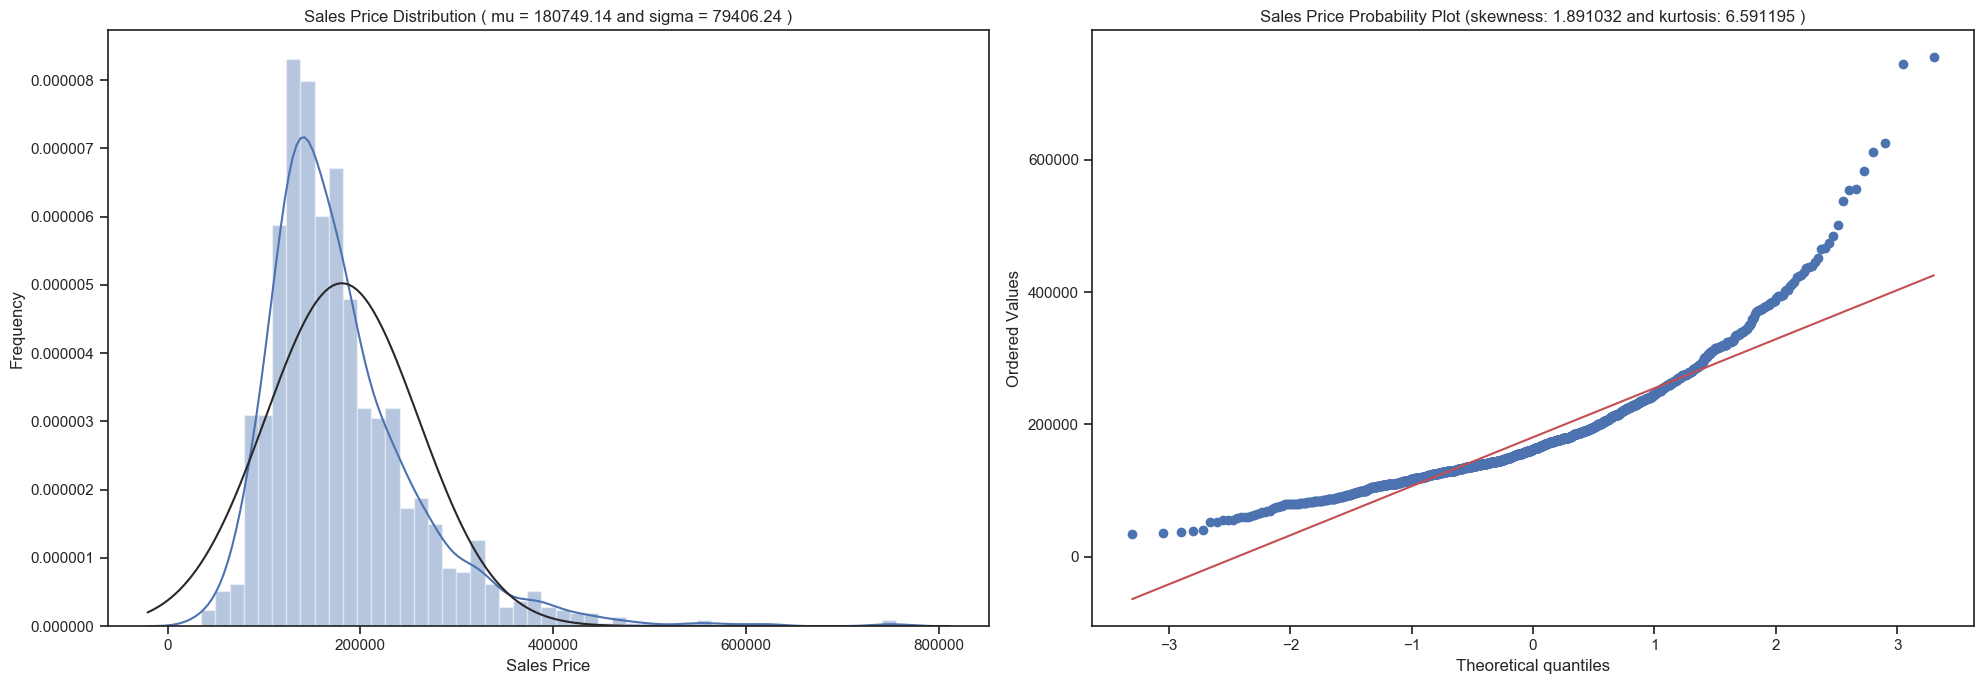

In [48]:
QQ_plot(train.SalePrice, 'Sales Price')


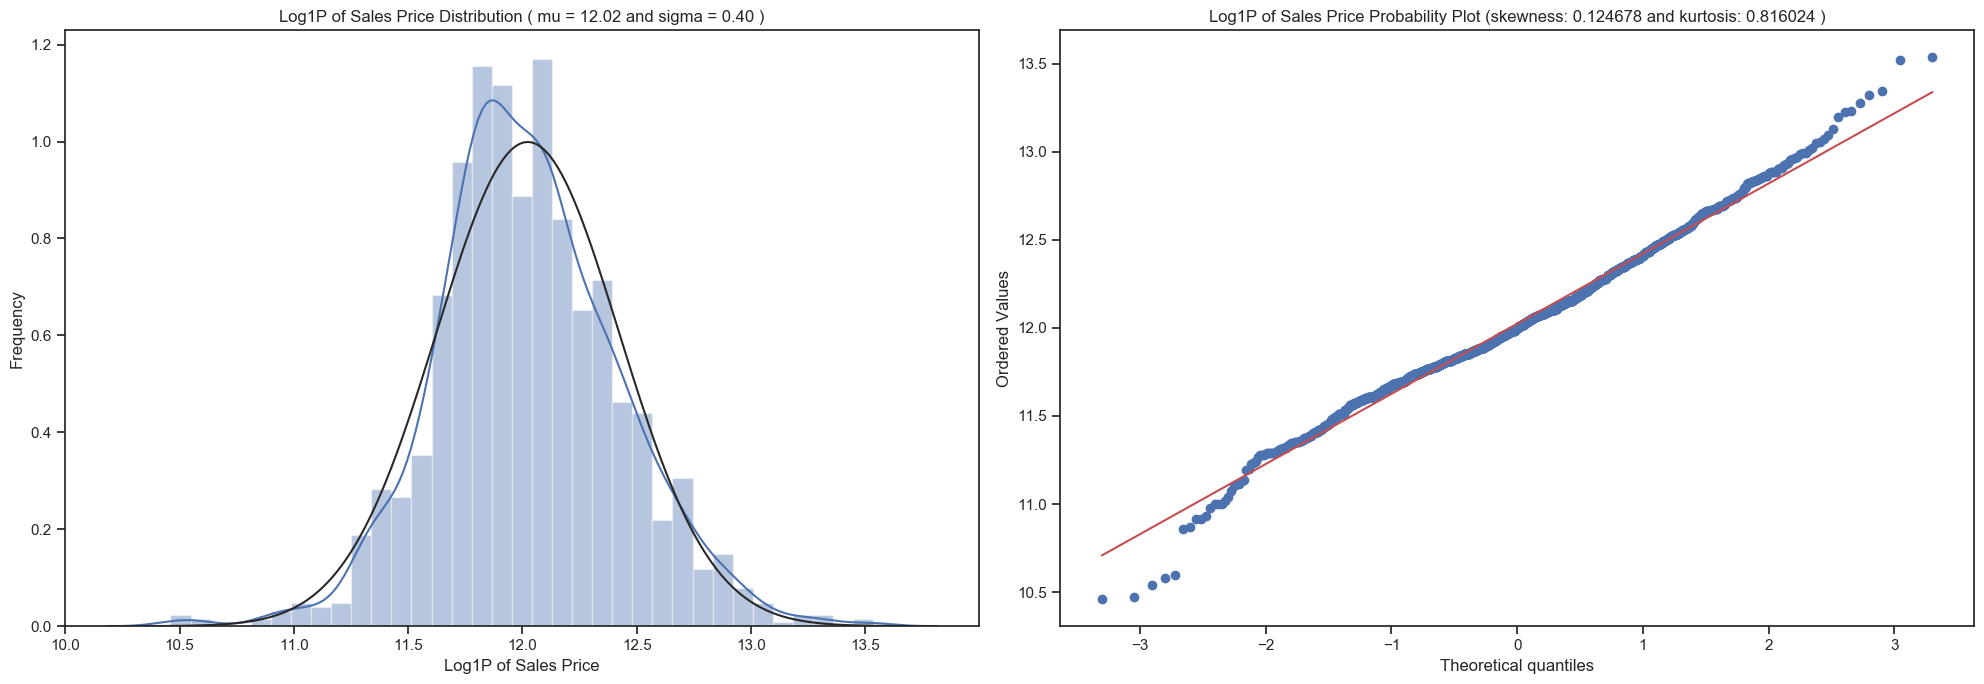

In [49]:
# Modifying all the elements in column with numpy fuction log1p which applies log(1+x)
train.SalePrice = np.log1p(train.SalePrice)

QQ_plot(train.SalePrice, 'Log1P of Sales Price')

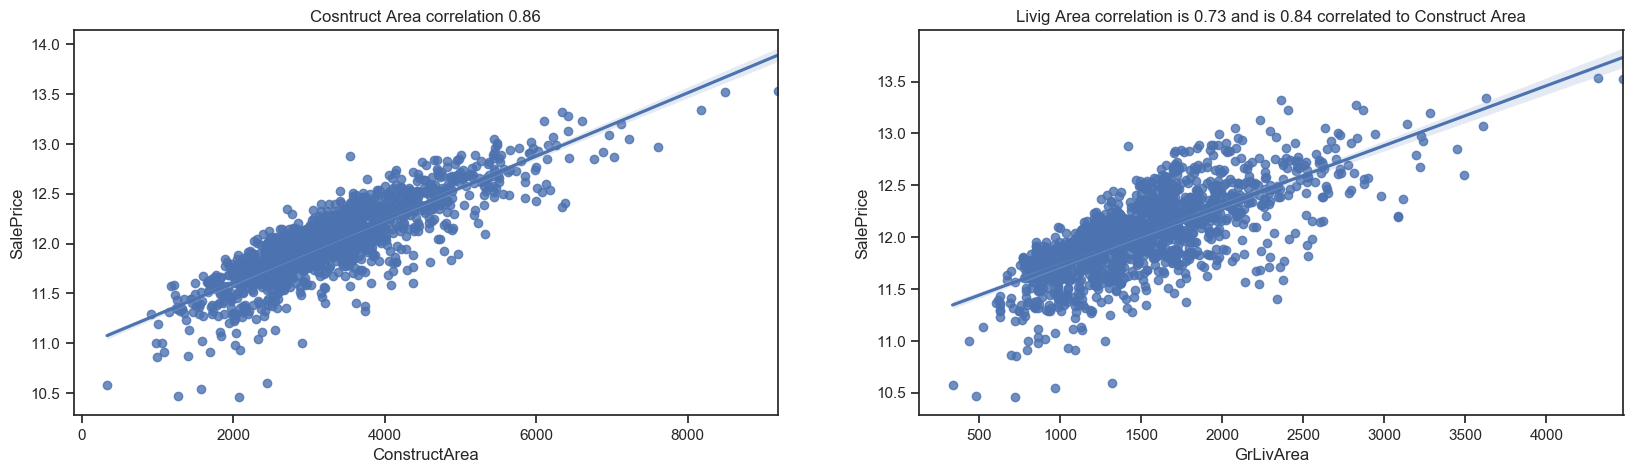

In [50]:
## Test hypothesis: Construction Area

df = train[['SalePrice', 'GrLivArea']]
df['ConstructArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                       train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + train.OpenPorchSF.fillna(0) + 
                       train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + train.EnclosedPorch.fillna(0) + 
                       train.PoolArea.fillna(0) )
                         
fig8 = plt.figure(figsize=(20,5))
fig9 = fig8.add_subplot(121); sns.regplot((df.ConstructArea), df.SalePrice)
plt.title('Cosntruct Area correlation {:1.2f}'.format(df.ConstructArea.corr(df.SalePrice)))

fig10 = fig8.add_subplot(122); sns.regplot((df.GrLivArea.fillna(0)), df.SalePrice)
tit = 'Livig Area correlation is {:1.2f} and is {:1.2f} correlated to Construct Area'
plt.title(tit.format(df.GrLivArea.fillna(0).corr(df.SalePrice), df.GrLivArea.corr(df.ConstructArea)))
plt.show()

In [51]:
def print_results():
    # The coefficients
    print('Coefficients: \n', lr.coef_)
    # The mean squared error
    print("Root mean squared error: %.4f"
          % np.expm1(np.sqrt(mean_squared_error(y_test, y_pred))))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % r2_score(y_test, y_pred))
    print('--------------------------------------------------------------------------------\n')
    
scale = RobustScaler()
y = df.SalePrice

X = scale.fit_transform(df[['ConstructArea', 'GrLivArea']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

lr = LinearRegression()

print('1. Linear regressor with only living Area:')
lr.fit(X_train[: , 1].reshape(-1, 1), y_train)

# Make predictions using the testing set
y_pred = lr.predict(X_test[: , 1].reshape(-1, 1))
print_results()

print('2. Linear regressor with bouth features:')
lr.fit(X_train, y_train)

# Makepredictions using the testing set
y_pred = lr.predict(X_test)
print_results()

print('3. Linear regressor with only Construct Area:')
lr = LinearRegression()
lr.fit(X_train[: , 0].reshape(-1, 1), y_train)

# Makepredictions using the testing set
y_pred = lr.predict(X_test[: , 0].reshape(-1, 1))
print_results()

print('4. Polinomial regressor of orden 3 with only Construction Area:')
# create polynomial features
cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_cubic = cubic.fit_transform(X_train[: , 0].reshape(-1, 1))

# cubic fit
lr = lr.fit(X_cubic, y_train)
y_pred = lr.predict(cubic.fit_transform(X_test[: , 0].reshape(-1, 1)))
print_results()

print('5. Polinomial regressor of orden 3 with both features:')
# create polynomial features
cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_cubic = cubic.fit_transform(X_train)

# cubic fit
lr = lr.fit(X_cubic, y_train)
y_pred = lr.predict(cubic.fit_transform(X_test))
print_results()

1. Linear regressor with only living Area:
Coefficients: 
 [0.37373448]
Root mean squared error: 0.3135
Variance score: 0.5547
--------------------------------------------------------------------------------

2. Linear regressor with bouth features:
Coefficients: 
 [0.40446921 0.02013973]
Root mean squared error: 0.2275
Variance score: 0.7484
--------------------------------------------------------------------------------

3. Linear regressor with only Construct Area:
Coefficients: 
 [0.42050449]
Root mean squared error: 0.2276
Variance score: 0.7481
--------------------------------------------------------------------------------

4. Polinomial regressor of orden 3 with only Construction Area:
Coefficients: 
 [ 0.437434   -0.0420375   0.00630214]
Root mean squared error: 0.2212
Variance score: 0.7608
--------------------------------------------------------------------------------

5. Polinomial regressor of orden 3 with both features:
Coefficients: 
 [ 0.41182783  0.03846449 -0.0503578

In [52]:
## Check Data Quality

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)

print("All data observations have {0} rows and {1} columns".format(all_data.shape[0], all_data.shape[1]))
details = rstr(all_data)
print("All data have {1:2.2%} of null at {0} features".format(details[details.nulls>0].shape[0], 
                                                   details.nulls[details.nulls>0].sum()/all_data.size))
print('\nBelow the table with all columns with nulls oredered by missin ration:')
display(details.loc[(details.nulls>0), 'types':'uniques'].sort_values(by= 'missing ration', ascending=False))



All data observations have 2908 rows and 80 columns
Data shape: (2908, 80)
___________________________
Data types:
 object     43
int64      25
float64    12
Name: types, dtype: int64
___________________________
All data have 5.98% of null at 34 features

Below the table with all columns with nulls oredered by missin ration:


,types,counts,distincts,nulls,missing ration,uniques
PoolQC,object,9,4,2899,99.691,"[nan, Ex, Fa, Gd]"
MiscFeature,object,104,5,2804,96.424,"[nan, Shed, Gar2, Othr, TenC]"
Alley,object,197,3,2711,93.226,"[nan, Grvl, Pave]"
Fence,object,570,5,2338,80.399,"[nan, MnPrv, GdWo, GdPrv, MnWw]"
FireplaceQu,object,1493,6,1415,48.659,"[nan, TA, Gd, Fa, Ex, Po]"
LotFrontage,float64,2423,129,485,16.678,"[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan..."
GarageFinish,object,2752,4,156,5.365,"[RFn, Unf, Fin, nan]"
GarageQual,object,2752,6,156,5.365,"[TA, Fa, Gd, nan, Ex, Po]"
GarageCond,object,2752,6,156,5.365,"[TA, Fa, nan, Gd, Po, Ex]"
GarageYrBlt,float64,2752,104,156,5.365,"[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993...."


In [53]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [54]:
all_data.drop('Utilities', axis=1, inplace=True)


In [55]:
display(all_data.Electrical.value_counts())

all_data.Electrical = all_data.Electrical.fillna('SBrkr')

SBrkr    2661
FuseA     187
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [56]:
feat = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']
print(all_data[feat].isnull().sum())
print("GarageArea equal a 0: ", (all_data.GarageArea==0).sum())
print("GarageCars equal a 0: ", (all_data.GarageCars==0).sum())
c = all_data[~all_data.GarageType.isnull()][feat]
c[c.GarageYrBlt.isnull()]

GarageYrBlt     156
GarageType      154
GarageFinish    156
GarageQual      156
GarageCond      156
GarageArea        1
GarageCars        1
dtype: int64
GarageArea equal a 0:  154
GarageCars equal a 0:  154


,GarageYrBlt,GarageType,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars
2115,NaN,Detchd,NaN,NaN,NaN,360.000,1.000
2565,NaN,Detchd,NaN,NaN,NaN,NaN,NaN


In [57]:
## Group by GarageType

all_data.GarageType = all_data.GarageType.fillna('NA')

# Group by GarageType and fill missing value with median where GarageType=='Detchd' and 0 for the others
cmedian = all_data[all_data.GarageType=='Detchd'].GarageArea.median()
print("GarageArea median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageArea'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageArea'].fillna(cmedian)
all_data.GarageArea = all_data.GarageArea.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageCars.median()
print("GarageCars median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCars'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCars'].fillna(cmedian)
all_data.GarageCars = all_data.GarageCars.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageYrBlt.median()
print("GarageYrBlt median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageYrBlt'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                          'GarageYrBlt'].fillna(cmedian)
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(0)

# Group by GarageType and fill missing value with mode where GarageType=='Detchd' and 'NA' for the others
cmode = all_data[all_data.GarageType=='Detchd'].GarageFinish.mode()[0]
print("GarageFinish mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageFinish'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                           'GarageFinish'].fillna(cmode)
all_data.GarageFinish = all_data.GarageFinish.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageQual.mode()[0]
print("GarageQual mode of Type Detchd: %s" %cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageQual'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageQual'].fillna(cmode)
all_data.GarageQual = all_data.GarageQual.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageCond.mode()[0]
print("GarageCond mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCond'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCond'].fillna(cmode)
all_data.GarageCond = all_data.GarageCond.fillna('NA')

GarageArea median of Type Detchd: 397.5
GarageCars median of Type Detchd: 2.0
GarageYrBlt median of Type Detchd: 1962.0
GarageFinish mode of Type Detchd: Unf
GarageQual mode of Type Detchd: TA
GarageCond mode of Type Detchd: TA


In [58]:
print(all_data[feat].isnull().sum())


GarageYrBlt     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageArea      0
GarageCars      0
dtype: int64


In [59]:
## Checking the data of Masonry veneer

feat = ['MasVnrArea', 'MasVnrType']
c = all_data[~all_data.MasVnrArea.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')
print("Has MasVnrType but not has MasVnrArea:",all_data[~all_data.MasVnrType.isnull()].MasVnrArea.isnull().sum())
print("Has MasVnrArea but not has MasVnrType:",c[c.MasVnrType.isnull()].MasVnrArea.count())
print(c[c.MasVnrType.isnull()], '\n')

print("Has MasVnrType but MasVnrArea is equal a Zero:",c[c.MasVnrArea==0].MasVnrType.count())
print("MasVnrArea equal a 0: ", (all_data.MasVnrArea==0).sum(), '\n')
print("Has Type and Area == 0:")
print(c[c.MasVnrArea==0].MasVnrType.value_counts(), '\n')

print("Type None with Area > 0 ?")
print(all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType','MasVnrArea']])

print('\n What is the most comumn MasVnrType after None?')
print(all_data.MasVnrType.value_counts())

Masonry veneer Nulls:
MasVnrArea    23
MasVnrType    24
dtype: int64 

Has MasVnrType but not has MasVnrArea: 0
Has MasVnrArea but not has MasVnrType: 1
      MasVnrArea MasVnrType
2599     198.000        NaN 

Has MasVnrType but MasVnrArea is equal a Zero: 1734
MasVnrArea equal a 0:  1734 

Has Type and Area == 0:
None       1731
BrkFace       2
Stone         1
Name: MasVnrType, dtype: int64 

Type None with Area > 0 ?
     MasVnrType  MasVnrArea
622        None     288.000
769        None       1.000
1222       None       1.000
1291       None     344.000
1325       None     312.000
1658       None     285.000
2441       None       1.000

 What is the most comumn MasVnrType after None?
None       1738
BrkFace     877
Stone       244
BrkCmn       25
Name: MasVnrType, dtype: int64


In [60]:
## Corrected data of Masonary Veneer

# All None Types with Are greater than 0 update to BrkFace type
all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

# All Types null with Are greater than 0 update to BrkFace type
all_data.loc[(all_data.MasVnrType.isnull()) & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

# All Types different from None with Are equal to 0 update to median Area of no None types with Areas
all_data.loc[(all_data.MasVnrType!='None') & 
             (all_data.MasVnrArea==0), ['MasVnrArea']] = all_data.loc[(all_data.MasVnrType!='None') & 
                                                                      (all_data.MasVnrArea>0), ['MasVnrArea']].median()[0]
# Filling 0 and None for records wheres both are nulls
all_data.MasVnrArea = all_data.MasVnrArea.fillna(0)
all_data.MasVnrType = all_data.MasVnrType.fillna('None')


In [61]:
## Checking the nulls in data of Masonry Veneer

c = all_data[~all_data.MasVnrType.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')


Masonry veneer Nulls:
MasVnrArea    0
MasVnrType    0
dtype: int64 



In [63]:
## Check and Input Basement Features Nulls:



feat = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 
        'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
print(all_data[feat].isnull().sum())
print("BsmtFinSF1 equal a 0: ", (all_data.BsmtFinSF1==0).sum())
print("BsmtFinSF2 equal a 0: ", (all_data.BsmtFinSF2==0).sum())
print("BsmtUnfSF equal a 0: ", (all_data.BsmtUnfSF==0).sum())
print("TotalBsmtSF equal a 0: ", (all_data.TotalBsmtSF==0).sum())
print("BsmtFullBath equal a 0: ", (all_data.BsmtFullBath==0).sum())
print("BsmtHalfBath equal a 0: ", (all_data.BsmtHalfBath==0).sum())

BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64
BsmtFinSF1 equal a 0:  927
BsmtFinSF2 equal a 0:  2560
BsmtUnfSF equal a 0:  240
TotalBsmtSF equal a 0:  78
BsmtFullBath equal a 0:  1702
BsmtHalfBath equal a 0:  2734


In [64]:
# Basement Value 
display(all_data.BsmtExposure.value_counts())

# Update nulls Exposure to Av wheres TotalBsmntSF is grenter tham zero 
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtExposure.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtExposure'] = 'Av'

No    1899
Av     417
Gd     271
Mn     239
Name: BsmtExposure, dtype: int64

In [65]:
# TA is the most common BsmtQual. 
display(all_data.BsmtQual.value_counts())

# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtQual.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtQual'] = 'TA'

TA    1278
Gd    1208
Ex     253
Fa      88
Name: BsmtQual, dtype: int64

In [66]:
# TA is the most common BsmtCond. 
display(all_data.BsmtCond.value_counts())

# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & (all_data.BsmtCond.isnull()) & (all_data.TotalBsmtSF>0), 'BsmtCond'] = 'TA'

TA    2597
Gd     121
Fa     103
Po       5
Name: BsmtCond, dtype: int64

In [67]:
# Unf is the most common BsmtFinType2. 
display(all_data.BsmtFinType2.value_counts())

# We use Unf for all cases wheres BsmtFinType2 is null but BsmtFinSF2 is grater than Zro
all_data.loc[(all_data.BsmtFinSF2>0) & (all_data.BsmtFinType2.isnull()) , 'BsmtFinType2'] = 'Unf'

Unf    2482
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

In [68]:
# See below that we have one case where BsmtFinType2 is BLQ and the Area is Zero, but its area was inputed at Unfinesh
display(all_data[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull())][feat])

# Correct BsmtFinSF2 and BsmtUnfSF:
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtFinSF2'] = 354.0
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtUnfSF'] = 0.0


,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
1459,1051.000,0.000,354.000,1405.000,1.000,0.000,Gd,TA,No,GLQ,BLQ


In [69]:
# All these cases are clear don´t have basement. 
print("Rest cases where Cond is Null", (all_data[all_data.BsmtCond.isnull()]).shape[0], '\n')
print('Others categories basement features are Null when Cond is Null:\n',
      (all_data[all_data.BsmtCond.isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure',
                                             'BsmtFinType1' , 'BsmtFinType2']]).isnull().sum())
print('\nOthers numerics basement features are Null or Zero when Cond is Null:\n',
      all_data[all_data.BsmtCond.isnull()][['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' ,'TotalBsmtSF',
                                            'BsmtFullBath', 'BsmtHalfBath']].sum())
print("\nThe particular cases where's numeric basement features see below are Null were included in the previous groups:") 
display(all_data[all_data.BsmtFullBath.isnull()][feat])

Rest cases where Cond is Null 79 

Others categories basement features are Null when Cond is Null:
 BsmtQual        79
BsmtCond        79
BsmtExposure    79
BsmtFinType1    79
BsmtFinType2    79
dtype: int64

Others numerics basement features are Null or Zero when Cond is Null:
 BsmtFinSF1     0.000
BsmtFinSF2     0.000
BsmtUnfSF      0.000
TotalBsmtSF    0.000
BsmtFullBath   0.000
BsmtHalfBath   0.000
dtype: float64

The particular cases where's numeric basement features see below are Null were included in the previous groups:


,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
2109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# So, we update these Zero or NA according to their dictionary:
nulls_cols = {'BsmtExposure': 'NA', 'BsmtFinType2': 'NA', 'BsmtQual': 'NA', 'BsmtCond': 'NA', 'BsmtFinType1': 'NA',
              'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0 ,'TotalBsmtSF': 0, 'BsmtFullBath': 0, 'BsmtHalfBath': 0}

all_data = all_data.fillna(value=nulls_cols)

print('\nFinal Check if all nulls basement features are treated:', all_data[feat].isnull().sum().sum())


Final Check if all nulls basement features are treated: 0


In [71]:
## Lot Frontage: Check and clean

# Group by Neigborhood and fill missing value with Lot frontage median of the respect Neigborhood
NegMean = all_data.groupby('Neighborhood').LotFrontage.mean()

all_data.loc.LotFrontage = all_data[['Neighborhood', 'LotFrontage']].\
                           apply(lambda x: NegMean[x.Neighborhood] if np.isnan(x.LotFrontage) else x.LotFrontage, axis=1)

In [72]:
## Quality Checks and cleaning 

PoolQC = {0: 'NA', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['PoolQC']] =\
        ((all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['OverallQual']]/2).round()).\
        apply(lambda x: x.map(PoolQC))

all_data.PoolQC = all_data.PoolQC.fillna('NA')



In [73]:
## Checking for any missing values and clearing the same

all_data.Functional = all_data.Functional.fillna('Typ')


In [74]:
## Fireplace quality - miss values treatment

all_data.loc[(all_data.Fireplaces==0) & (all_data.FireplaceQu.isnull()), ['FireplaceQu']] = 'NA'


In [75]:
# Kitchen quality check

all_data.loc[(all_data.KitchenAbvGr>0) & (all_data.KitchenQual.isnull()), 
             ['KitchenQual']] = all_data.KitchenQual.mode()[0]


In [76]:
# Alley, Fence and Misc Features - cleaning the data

all_data.Alley = all_data.Alley.fillna('NA')
all_data.Fence = all_data.Fence.fillna('NA')
all_data.MiscFeature = all_data.MiscFeature.fillna('NA')

In [77]:
## Garage build of the year from 2207

display(all_data.loc[all_data.GarageYrBlt==2207, ['GarageYrBlt', 'YearBuilt']])
all_data.loc[all_data.GarageYrBlt==2207.0, 'GarageYrBlt'] = 2007.0

,GarageYrBlt,YearBuilt
2581,2207.000,2006


In [78]:
## Cleaning all data with filling in nas

all_data = DataFrameImputer().fit_transform(all_data)

# Final check if we have some NA
print("Data nulls:", all_data.isnull().sum().sum())


Data nulls: 0


In [79]:
## Mapping some features

def map_ordinals(data):
    
    # LandSlope: Slope of property
    LandSlope = {}
    LandSlope['Gtl'] = 3 #'Gentle slope'
    LandSlope['Mod'] = 2 #'Moderate Slope'
    LandSlope['Sev'] = 1 #'Severe Slope'

    data.LandSlope = data.LandSlope.map(LandSlope)
        
    # ExterQual: Evaluates the quality of the material on the exterior 
    ExterQual = {}
    ExterQual['Ex'] = 5 #'Excellent'
    ExterQual['Gd'] = 4 #'Good'
    ExterQual['TA'] = 3 #'Average/Typical'
    ExterQual['Fa'] = 2 #'Fair'
    ExterQual['Po'] = 1 #'Poor'
    ExterQual['NA'] = 0 #'NA'

    data.ExterQual = data.ExterQual.map(ExterQual)

    # ExterCond: Evaluates the present condition of the material on the exterior
    data.ExterCond = data.ExterCond.map(ExterQual)

    #HeatingQC: Heating quality and condition
    data.HeatingQC = data.HeatingQC.map(ExterQual)

    # KitchenQual: Kitchen quality
    data.KitchenQual = data.KitchenQual.map(ExterQual)

    # FireplaceQu: Fireplace quality
    data.FireplaceQu = data.FireplaceQu.map(ExterQual)

    # GarageCond: Garage Conditionals
    data.GarageCond = data.GarageCond.map(ExterQual)

    PavedDrive = {}
    PavedDrive['Y'] = 3 #'Paved'
    PavedDrive['P'] = 2 #'Partial Pavement'
    PavedDrive['N'] = 1 #'Dirt/Gravel'

    data.PavedDrive = data.PavedDrive.map(PavedDrive)

    # LotShape: General shape of property
    LotShape = {}
    LotShape['Reg'] = 4 #'Regular'
    LotShape['IR1'] = 3 #'Slightly irregular'
    LotShape['IR2'] = 2 #'Moderately Irregular'
    LotShape['IR3'] = 1 #'Irregular'

    data.LotShape = data.LotShape.map(LotShape)

    # BsmtQual: Evaluates the height of the basement
    BsmtQual = {}
    BsmtQual['Ex'] = 5 #'Excellent (100+ inches)'
    BsmtQual['Gd'] = 4 #'Good (90-99 inches)'
    BsmtQual['TA'] = 3 #'Typical (80-89 inches)'
    BsmtQual['Fa'] = 2 #'Fair (70-79 inches)'
    BsmtQual['Po'] = 1 #'Poor (<70 inches'
    BsmtQual['NA'] = 0 #'No Basement'

    data.BsmtQual = data.BsmtQual.map(BsmtQual)

    # BsmtCond: Evaluates the general condition of the basement
    data.BsmtCond = data.BsmtCond.map(BsmtQual)

    # GarageQual: Garage quality
    data.GarageQual = data.GarageQual.map(BsmtQual)

    # PoolQC: Pool quality
    data.PoolQC = data.PoolQC.map(BsmtQual)
    
    # BsmtExposure: Refers to walkout or garden level walls
    BsmtExposure = {}
    BsmtExposure['Gd'] = 4 #'Good Exposure'
    BsmtExposure['Av'] = 3 #'Average Exposure (split levels or foyers typically score average or above)'
    BsmtExposure['Mn'] = 2 #'Mimimum Exposure'
    BsmtExposure['No'] = 1 #'No Exposure'
    BsmtExposure['NA'] = 0 #'No Basement'

    data.BsmtExposure = data.BsmtExposure.map(BsmtExposure)

    # BsmtFinType1: Rating of basement finished area
    BsmtFinType1 = {}
    BsmtFinType1['GLQ'] = 6 #'Good Living Quarters'
    BsmtFinType1['ALQ'] = 5 # 'Average Living Quarters'
    BsmtFinType1['BLQ'] = 4 # 'Below Average Living Quarters'
    BsmtFinType1['Rec'] = 3 # 'Average Rec Room'
    BsmtFinType1['LwQ'] = 2 # 'Low Quality'
    BsmtFinType1['Unf'] = 1 # 'Unfinshed'
    BsmtFinType1['NA'] = 0 #'No Basement'

    data.BsmtFinType1 = data.BsmtFinType1.map(BsmtFinType1)

    # BsmtFinType2: Rating of basement finished area (if multiple types)
    data.BsmtFinType2 = data.BsmtFinType2.map(BsmtFinType1)

    #CentralAir: Central air conditioning
    # Since with this transformatio as the same as binarize this feature
    CentralAir = {}
    CentralAir['N'] = 0
    CentralAir['Y'] = 1

    data.CentralAir = data.CentralAir.map(CentralAir)

    # GarageFinish: Interior finish of the garage
    GarageFinish = {}
    GarageFinish['Fin'] = 3 #'Finished'
    GarageFinish['RFn'] = 2 #'Rough Finished'
    GarageFinish['Unf'] = 1 #'Unfinished'
    GarageFinish['NA'] = 0 #'No Garage'
    
    data.GarageFinish = data.GarageFinish.map(GarageFinish)
    
    # Functional: Home functionality
    Functional = {}
    Functional['Typ'] = 7   # Typical Functionality
    Functional['Min1'] = 6  # Minor Deductions 1
    Functional['Min2'] = 5  # Minor Deductions 2
    Functional['Mod'] = 4   # Moderate Deductions
    Functional['Maj1'] = 3  # Major Deductions 1
    Functional['Maj2'] = 2  # Major Deductions 2
    Functional['Sev'] = 1   # Severely Damaged
    Functional['Sal'] = 0   # Salvage only

    data.Functional = data.Functional.map(Functional)
    
    #Street: Type of road access to property
    # Since with this transformatio as the same as binarize this feature
    Street = {}
    Street['Grvl'] = 0 # Gravel 
    Street['Pave'] = 1 # Paved

    data.Street = data.Street.map(Street)


    # Fence: Fence quality
    Fence = {}
    Fence['GdPrv'] = 5 #'Good Privacy'
    Fence['MnPrv'] = 4 #'Minimum Privacy'
    Fence['GdWo'] = 3 #'Good Wood'
    Fence['MnWw'] = 2 #'Minimum Wood/Wire'
    Fence['NA'] = 1 #'No Fence'

    data.Fence = data.Fence.map(Fence)
    #But No Fence has the higest median Sales Price. So I try to use it as categorical
            
    return data

all_data = map_ordinals(all_data)

In [80]:
## Include pool in the mics features

display(all_data.loc[(all_data.PoolArea>0) & (all_data.MiscVal>0), ['MiscFeature', 'MiscVal', 'PoolArea', 'PoolQC']])


,MiscFeature,MiscVal,PoolArea,PoolQC
1376,TenC,2000,519,2


In [82]:
## Check if we had others "TenC" in the dataset:



display(all_data.loc[(all_data.MiscFeature=='TenC'), ['MiscFeature', 'MiscVal', 'PoolArea', 'PoolQC']])


,MiscFeature,MiscVal,PoolArea,PoolQC
1376,TenC,2000,519,2


In [83]:
all_data.loc[(all_data.PoolArea>0), ['MiscFeature']] = 'Pool'
all_data.loc[(all_data.PoolArea>0), ['MiscVal']] = all_data.loc[(all_data.PoolArea>0), 
                                                               ['MiscVal', 'PoolArea']].\
                                                                apply(lambda x: (x.MiscVal + x.PoolArea), axis=1)
